# Import libraries

In [166]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display


## Import Functions

### dslabs_functions

In [167]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


### data functions

In [168]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [169]:
#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/citi_bike_pre_proc.csv'

excel_mapping_filepath=r'data/citi_bike_values_encoded.xlsx'

file_tag = 'Citi Bike'

#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase

In [292]:
test_data = True
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.007, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

id_cols=['ride_id',
         'start_time', 
         'end_time',
         'start_station',
         'end_station',
         'start_station_id',
         'end_station_id',
         'start_lat',
         'start_lng', 
         #'hour',
         'end_lat', 
         'end_lng',
         'wmo_weather_code',
         'snowfall_cm',
         'ride_duration_sec']
#remove also col = 'snowfall_cm' because it has only 0 values in our dataset
#remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow

# Remove unnecessary columns
df = df.drop(columns=id_cols, axis=1)

df_enc = df.copy()  # DataFrame com as variáveis codificadas

display(df_enc.info())
display(df_enc.shape)


#alterar consoante a necessidade:
#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
use_df_in_scaling = "df_prep_outl_trunc_final"  # Pode ser "df_enc" ou "df_prep_outl"
use_df_in_feat_eng = "df_prep_scal"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal"
use_df_in_clust = "df_prep_feat"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal", "df_prep_feat_eng"


<class 'pandas.core.frame.DataFrame'>
Index: 22355 entries, 2509920 to 536929
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bike_type            22355 non-null  object 
 1   user_type            22355 non-null  object 
 2   start_borough        22355 non-null  object 
 3   end_borough          22355 non-null  object 
 4   day_of_month         22355 non-null  int64  
 5   hour                 22355 non-null  int64  
 6   day_of_week          22355 non-null  object 
 7   is_weekend           22355 non-null  int64  
 8   time_of_day          22355 non-null  object 
 9   ride_duration_min    22355 non-null  float64
 10  temperature_2m       22355 non-null  float64
 11  rain_mm              22355 non-null  float64
 12  cloud_cover_low_pct  22355 non-null  int64  
 13  wind_speed_10m       22355 non-null  float64
 14  wmo_weather_desc     22355 non-null  object 
 15  ride_distance_km     22355 non-nul

None

(22355, 17)

In [293]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
bike_type                  2
user_type                  2
start_borough              5
end_borough                6
day_of_month              31
hour                      24
day_of_week                7
is_weekend                 2
time_of_day                4
ride_duration_min      22169
temperature_2m           213
rain_mm                   29
cloud_cover_low_pct       72
wind_speed_10m           255
wmo_weather_desc           9
ride_distance_km       21336
ride_avg_speed         22132
dtype: int64


# Cluster Data Enconding


In [294]:
df_enc.shape

(22355, 17)

# Encoding Detail

- Ordinal enconding:
  - bike_type
    - 0: classic
    - 1: eletric
  - user_type
    - 0: casual
    - 1: member

- Hierachical encoding: Simbolyic Variables
  - start_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
  - end_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
 

- Cyclical enconding: Simbolyic Variables
  - day_of_week
  - time_of_day
  - hour

- Dummyfication:
  - start_borough
  - end_borough
  - wmo_weather_desc 


- Numeric Values that don't need encoding
  - hour
  - day_of_month
  - is_weekend
  - ride_duration_min
  - temperature_2m
  - rain_mm
  - wmo_weather_code ?????
  - cloud_cover_low_pct
  - wind_speed_10m
  - ride_distance_km
  - ride_avg_speed

Note: week_of_month and day in our case are ordinal variables, and not cyclical, because our dataset only has data for 1 month, nov/19, which means that these two variables don't repeat over time in our dataset.

## Ordinal enconding





In [296]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['day_of_month', 'hour', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


In [180]:
df.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
1956998,electric_bike,member,Manhattan,Manhattan,28,16,Sunday,1,afternoon,16.796000,19.5,0.0,0,15.9,Overcast,1.899617,6.785961
1791342,electric_bike,casual,Manhattan,Brooklyn,28,18,Sunday,1,evening,21.585283,17.5,0.0,16,5.6,Overcast,4.581006,12.733692
457396,electric_bike,member,Brooklyn,Brooklyn,23,23,Tuesday,0,night,6.859900,8.7,0.0,0,12.1,Overcast,1.171177,10.243684
2783650,electric_bike,casual,Manhattan,Manhattan,14,19,Sunday,1,evening,7.588267,19.4,0.0,0,20.3,Overcast,1.627987,12.872404
3148647,electric_bike,casual,Brooklyn,Brooklyn,25,20,Thursday,0,evening,7.562650,6.0,0.0,0,8.3,Overcast,2.000081,15.868098


##### bulk Symbolic mapping through Excel

    - Simbolyc
        -...

    - Binary
        - is_weekend
        - bike_type
            - 0: classic
            - 1: eltric
        - user_type
            - 0: classic
            - 1: member
        - wmo_weather_desc
            - Hierarychal order. Basically, main sky is more closer than overcast than with Rain day

In [297]:


# Generalized function to encode any column based on a mapping dictionary
def encode_column_with_mapping(df, column, mapping_dict, default_value=np.nan):
    """
    Encode a column based on a mapping dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to encode.
    column (str): The column name to encode.
    mapping_dict (dict): Dictionary where keys are the original values and values are the encodings.
    default_value: Value to assign if the key is not found in the mapping dict (default is NaN).
    
    Returns:
    pd.Series: Encoded column.
    """
    return df[column].map(mapping_dict).fillna(default_value)



def sheet_to_dict(excel_file, sheet_name):
    """
    Converts a sheet in an Excel file to a dictionary with the first column as the key and the second as the value.
    
    Args:
    excel_file (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to convert.
    
    Returns:
    dict: A dictionary with keys from the first column and values from the second column.
    """
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Ensure that there are at least two columns
    if df.shape[1] < 2:
        raise ValueError(f"The sheet '{sheet_name}' does not have at least two columns.")
    
    # Create a dictionary from the first and second columns
    mapping_dict = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    
    return mapping_dict



In [298]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in df_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)
        
        # Encode the corresponding column in data_enc using the mapping
        df_enc[sheet] = encode_column_with_mapping(df_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")




bike_type column encoded
user_type column encoded
wmo_weather_desc column encoded


In [299]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2509920,1,1,Manhattan,Manhattan,9,18,Tuesday,0,evening,32.093883,14.6,0.0,0,18.2,3,0.728760,1.362429
764500,0,1,Manhattan,Manhattan,30,8,Tuesday,0,morning,5.470650,13.7,0.0,100,13.2,3,0.632436,6.936313
585092,1,1,Manhattan,Manhattan,4,8,Thursday,0,morning,4.953583,3.5,0.0,100,20.6,3,0.761511,9.223753
1609314,1,0,Manhattan,Manhattan,20,18,Saturday,1,evening,23.691217,15.6,0.0,0,22.7,0,4.272630,10.820796
2424139,1,1,Manhattan,Manhattan,25,19,Thursday,0,evening,9.947900,6.6,0.0,0,11.8,2,3.240218,19.543125


In [184]:
df_enc.shape

(22355, 17)

In [185]:
df_enc['wmo_weather_desc'].value_counts()

wmo_weather_desc
3     9558
0     6012
1     2092
6     1760
2     1746
7      684
11     334
8       88
12      81
Name: count, dtype: int64

In [300]:
for v in variable_types["numeric"]:
    print(v, df_enc[v].unique())

day_of_month [ 9 30  4 20 25 28 24 12 26 17 22 29 13 19  6  8 16  1 10  3 21 11  5  7
 18 15 23 27 14  2 31]
hour [18  8 19 16 17 21 14 15 12  7 11 22  9  6 23 10  2 20 13  0  1  5  3  4]
ride_duration_min [32.09388333  5.47065     4.95358333 ...  9.10871667 14.84538333
 10.94053333]
temperature_2m [14.6 13.7  3.5 15.6  6.6 19.5 17.3 12.6 13.  12.  14.4 11.2 27.1  8.6
  8.9 12.3 16.3 22.3 16.9 18.9  4.4 17.8 17.1 12.4 15.3  7.5 21.  20.3
 18.2 19.9 14.8 13.5  9.7 17.2 10.5 15.   5.2  8.8  7.1  6.8  8.5 13.8
 10.   5.4  5.8 23.8 10.1  7.6 12.1  9.6  5.9 23.7 15.2 18.  10.6 13.3
  8.7 22.2 17.5 10.3 20.2 18.4 15.5 11.4 11.  13.4 17.7 16.6 11.7 17.
  8.1  8.4 16.8 10.8 15.9 14.  21.1 21.4 24.4 12.5  6.7  7.3  6.5 12.7
 10.4  8.2  9.2 20.6 25.   9.9 22.6 14.3  4.6 15.7  9.8 18.6 22.7  9.
 13.1 21.7 20.1 18.3 23.1 14.5  6.4 19.8 14.1 10.7  7.9 24.5  6.1 20.
 19.4  3.8  5.5 11.8  5.6 18.5  5.1 11.3  3.3 20.8  9.1 19.1 12.8  9.4
 16.2 19.6 13.2  9.5 22.4  8.  16.1 14.2 17.9 23.6 19.2 11.9 26.

In [301]:
# Atualiza a lista de variáveis simbólicas após a codificação
variable_types["symbolic"] = [v for v in variable_types["symbolic"] if v in df_enc.select_dtypes(include=['object']).columns]


In [302]:
for v in variable_types["symbolic"]:
    print(v, df_enc[v].unique())

start_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island']
end_borough ['Manhattan' 'Brooklyn' 'Bronx' 'Queens' 'Jersey City' 'Staten Island']
day_of_week ['Tuesday' 'Thursday' 'Saturday' 'Sunday' 'Wednesday' 'Friday' 'Monday']
time_of_day ['evening' 'morning' 'afternoon' 'night']


In [189]:
df_enc['wmo_weather_desc'].value_counts()

wmo_weather_desc
3     9558
0     6012
1     2092
6     1760
2     1746
7      684
11     334
8       88
12      81
Name: count, dtype: int64

## Cyclical enconding
- We have variables, time variables, that are cyclical, meaning that the values of the variables can repeat over time. 
    - day_of_week
    - time_of_day
    - hour


So basicaly, if we look to time_of_day (morning, afternoon, night). Night is close to afternoon but is also at the same distant from morning, becase after night we will have the monrning

In [303]:
from math import pi, sin, cos


day_of_week_val: dict[str, float] = {
    "Sunday": 0,           # Domingo
    "Monday": 2 * pi / 7,  # Segunda-feira
    "Tuesday": 4 * pi / 7, # Terça-feira
    "Wednesday": 6 * pi / 7, # Quarta-feira
    "Thursday": 8 * pi / 7,  # Quinta-feira
    "Friday": 10 * pi / 7,  # Sexta-feira
    "Saturday": 12 * pi / 7  # Sábado
}

time_of_day_val: dict[str, float] = {
    'night': 0,             # Noite (até 6h)
    'morning': pi/5,        # Manhã cedo (6h - 12h)
    'afternoon': pi,        # Tarde (14h - 17h)
    'evening': -pi/2,       # Fim da tarde (17h - 22h)
}

# Dicionário de encoding apenas para as variáveis categóricas
encoding: dict[str, dict] = {
    "day_of_week": day_of_week_val,
    "time_of_day": time_of_day_val,
}

# Aplicar o encoding categórico ao DataFrame
df_enc = df_enc.replace(encoding)

df_enc.head(10)

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2509920,1,1,Manhattan,Manhattan,9,18,1.795196,0,-1.570796,32.093883,14.6,0.0,0,18.2,3,0.728760,1.362429
764500,0,1,Manhattan,Manhattan,30,8,1.795196,0,0.628319,5.470650,13.7,0.0,100,13.2,3,0.632436,6.936313
585092,1,1,Manhattan,Manhattan,4,8,3.590392,0,0.628319,4.953583,3.5,0.0,100,20.6,3,0.761511,9.223753
1609314,1,0,Manhattan,Manhattan,20,18,5.385587,1,-1.570796,23.691217,15.6,0.0,0,22.7,0,4.272630,10.820796
2424139,1,1,Manhattan,Manhattan,25,19,3.590392,0,-1.570796,9.947900,6.6,0.0,0,11.8,2,3.240218,19.543125
2021408,1,1,Brooklyn,Brooklyn,28,16,0.000000,1,3.141593,9.734350,19.5,0.0,0,15.9,3,3.111587,19.179015
938575,0,1,Manhattan,Manhattan,24,17,2.692794,0,-1.570796,9.515550,17.3,0.0,17,25.7,1,2.028625,12.791428
1990005,1,1,Manhattan,Manhattan,12,21,4.487990,0,0.000000,25.116917,12.6,0.0,0,18.3,0,3.988782,9.528516
2066963,0,1,Queens,Brooklyn,26,14,4.487990,0,3.141593,2.292800,13.0,0.0,1,18.4,2,0.281749,7.373055
757792,1,1,Manhattan,Manhattan,17,15,2.692794,0,3.141593,10.367300,12.0,0.4,21,16.2,6,0.310332,1.796024


In [304]:
# Função para aplicar encoding cíclico
def encode_cyclic_variables(df_enc, vars):
    for v in vars:
        # Ajustar x_max para cada variável cíclica
        if v == "hour":
            x_max = 24  # Ciclo de 24 horas
        elif v == "time_of_day":
            x_max = 4   # Ciclo de 4 períodos do dia
        elif v == "day_of_week":
            x_max = 7   # Ciclo de 7 dias da semana
        else:
            x_max = max(df_enc[v])  # Para outras variáveis (se houver)

        # Aplicar sin e cos para a variável
        df_enc[v + "_sin"] = df_enc[v].apply(lambda x: round(sin(2 * pi * x / x_max), 3))
        df_enc[v + "_cos"] = df_enc[v].apply(lambda x: round(cos(2 * pi * x / x_max), 3))
    
    return df_enc

# Variáveis cíclicas que já estão numericamente codificadas ou são numéricas
cyclical_vars = ["time_of_day", "day_of_week", "hour"]

# Aplicar a codificação cíclica
df_enc = encode_cyclic_variables(df_enc, cyclical_vars)

# Verificar os resultados
df_enc.head(15)


,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,...,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2509920,1,1,Manhattan,Manhattan,9,18,1.795196,0,-1.570796,32.093883,...,18.2,3,0.728760,1.362429,-0.624,-0.781,0.999,-0.041,-1.000,-0.000
764500,0,1,Manhattan,Manhattan,30,8,1.795196,0,0.628319,5.470650,...,13.2,3,0.632436,6.936313,0.834,0.551,0.999,-0.041,0.866,-0.500
585092,1,1,Manhattan,Manhattan,4,8,3.590392,0,0.628319,4.953583,...,20.6,3,0.761511,9.223753,0.834,0.551,-0.081,-0.997,0.866,-0.500
1609314,1,0,Manhattan,Manhattan,20,18,5.385587,1,-1.570796,23.691217,...,22.7,0,4.272630,10.820796,-0.624,-0.781,-0.993,0.121,-1.000,-0.000
2424139,1,1,Manhattan,Manhattan,25,19,3.590392,0,-1.570796,9.947900,...,11.8,2,3.240218,19.543125,-0.624,-0.781,-0.081,-0.997,-0.966,0.259
2021408,1,1,Brooklyn,Brooklyn,28,16,0.000000,1,3.141593,9.734350,...,15.9,3,3.111587,19.179015,-0.975,0.221,0.000,1.000,-0.866,-0.500
938575,0,1,Manhattan,Manhattan,24,17,2.692794,0,-1.570796,9.515550,...,25.7,1,2.028625,12.791428,-0.624,-0.781,0.663,-0.749,-0.966,-0.259
1990005,1,1,Manhattan,Manhattan,12,21,4.487990,0,0.000000,25.116917,...,18.3,0,3.988782,9.528516,0.000,1.000,-0.775,-0.632,-0.707,0.707
2066963,0,1,Queens,Brooklyn,26,14,4.487990,0,3.141593,2.292800,...,18.4,2,0.281749,7.373055,-0.975,0.221,-0.775,-0.632,-0.500,-0.866
757792,1,1,Manhattan,Manhattan,17,15,2.692794,0,3.141593,10.367300,...,16.2,6,0.310332,1.796024,-0.975,0.221,0.663,-0.749,-0.707,-0.707


In [192]:
print(df_enc.dtypes) 


bike_type                int64
user_type                int64
start_borough           object
end_borough             object
day_of_month             int64
hour                     int64
day_of_week            float64
is_weekend               int64
time_of_day            float64
ride_duration_min      float64
temperature_2m         float64
rain_mm                float64
cloud_cover_low_pct      int64
wind_speed_10m         float64
wmo_weather_desc         int64
ride_distance_km       float64
ride_avg_speed         float64
time_of_day_sin        float64
time_of_day_cos        float64
day_of_week_sin        float64
day_of_week_cos        float64
hour_sin               float64
hour_cos               float64
dtype: object


In [305]:
# Remover as colunas originais
df_enc = df_enc.drop(columns=["time_of_day", "day_of_week", "hour"])

# Verificar os resultados
df_enc.head(15)

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2509920,1,1,Manhattan,Manhattan,9,0,32.093883,14.6,0.0,0,18.2,3,0.728760,1.362429,-0.624,-0.781,0.999,-0.041,-1.000,-0.000
764500,0,1,Manhattan,Manhattan,30,0,5.470650,13.7,0.0,100,13.2,3,0.632436,6.936313,0.834,0.551,0.999,-0.041,0.866,-0.500
585092,1,1,Manhattan,Manhattan,4,0,4.953583,3.5,0.0,100,20.6,3,0.761511,9.223753,0.834,0.551,-0.081,-0.997,0.866,-0.500
1609314,1,0,Manhattan,Manhattan,20,1,23.691217,15.6,0.0,0,22.7,0,4.272630,10.820796,-0.624,-0.781,-0.993,0.121,-1.000,-0.000
2424139,1,1,Manhattan,Manhattan,25,0,9.947900,6.6,0.0,0,11.8,2,3.240218,19.543125,-0.624,-0.781,-0.081,-0.997,-0.966,0.259
2021408,1,1,Brooklyn,Brooklyn,28,1,9.734350,19.5,0.0,0,15.9,3,3.111587,19.179015,-0.975,0.221,0.000,1.000,-0.866,-0.500
938575,0,1,Manhattan,Manhattan,24,0,9.515550,17.3,0.0,17,25.7,1,2.028625,12.791428,-0.624,-0.781,0.663,-0.749,-0.966,-0.259
1990005,1,1,Manhattan,Manhattan,12,0,25.116917,12.6,0.0,0,18.3,0,3.988782,9.528516,0.000,1.000,-0.775,-0.632,-0.707,0.707
2066963,0,1,Queens,Brooklyn,26,0,2.292800,13.0,0.0,1,18.4,2,0.281749,7.373055,-0.975,0.221,-0.775,-0.632,-0.500,-0.866
757792,1,1,Manhattan,Manhattan,17,0,10.367300,12.0,0.4,21,16.2,6,0.310332,1.796024,-0.975,0.221,0.663,-0.749,-0.707,-0.707


In [195]:
display(df_enc.shape)
display(df_enc.columns)

(22355, 20)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [306]:
# Criar uma lista para armazenar os valores distintos
distinct_values = {}

# Variáveis cíclicas que você criou
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Loop para obter valores distintos de cada coluna sin e cos
for var in cyclical_vars:
    distinct_sin = df_enc[f'{var}_sin'].unique()
    distinct_cos = df_enc[f'{var}_cos'].unique()
    
    # Armazenar os valores distintos em um dicionário
    distinct_values[f'{var}_sin'] = distinct_sin
    distinct_values[f'{var}_cos'] = distinct_cos

# Imprimir os valores distintos
for key, values in distinct_values.items():
    print(f"Valores distintos de {key}:", values)


Valores distintos de time_of_day_sin: [-0.624  0.834 -0.975  0.   ]
Valores distintos de time_of_day_cos: [-0.781  0.551  0.221  1.   ]
Valores distintos de day_of_week_sin: [ 0.999 -0.081 -0.993  0.     0.663 -0.775  0.721]
Valores distintos de day_of_week_cos: [-0.041 -0.997  0.121  1.    -0.749 -0.632  0.693]
Valores distintos de hour_sin: [-1.     0.866 -0.966 -0.866 -0.707 -0.5    0.     0.966  0.259  0.707
  1.    -0.259  0.5  ]
Valores distintos de hour_cos: [-0.    -0.5    0.259 -0.259  0.707 -0.866 -0.707 -1.    -0.966  0.866
  0.966  0.5    1.   ]


##### Visual representation of cyclical variables

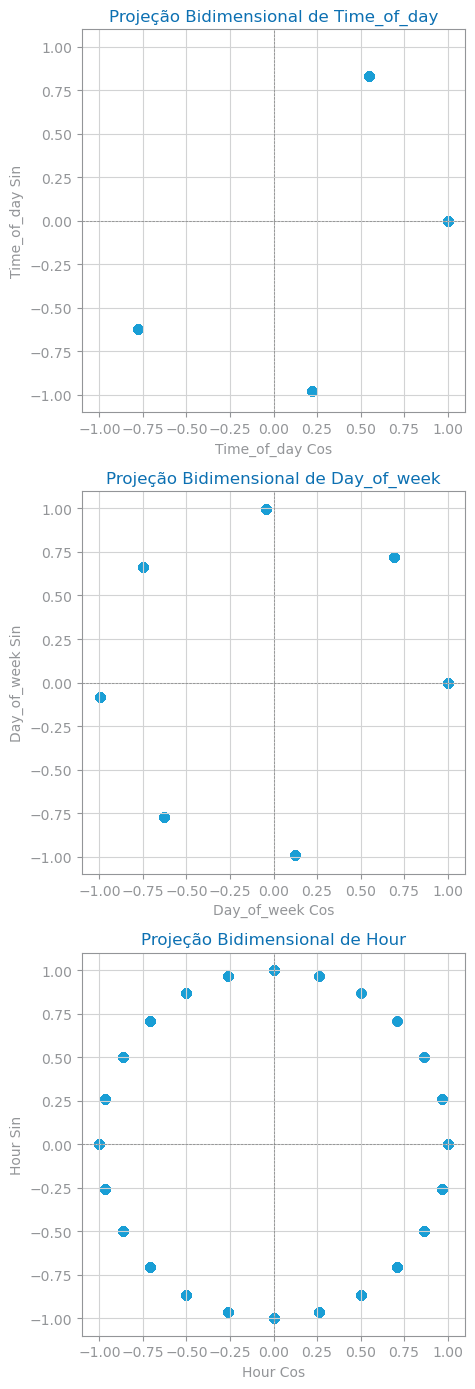

In [307]:
import matplotlib.pyplot as plt

# Lista de variáveis cíclicas
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Criar gráficos de dispersão para cada variável cíclica com tamanho maior
plt.figure(figsize=(14, 14))  # Aumentando o tamanho da figura

for i, var in enumerate(cyclical_vars):
    # Valores de seno e cosseno para a variável atual
    x_values = df_enc[f'{var}_cos']
    y_values = df_enc[f'{var}_sin']
    
    # Criar um subplot para cada variável
    plt.subplot(len(cyclical_vars), 1, i + 1)
    plt.scatter(x_values, y_values, alpha=0.6)
    plt.axhline(0, color='gray', lw=0.5, ls='--')
    plt.axvline(0, color='gray', lw=0.5, ls='--')
    
    # Ajustar os limites dos eixos para melhor visualização
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    
    # Adicionar título e rótulos
    plt.title(f'Projeção Bidimensional de {var.capitalize()}')
    plt.xlabel(f'{var.capitalize()} Cos')
    plt.ylabel(f'{var.capitalize()} Sin')
    
    # Mostrar a grade
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')  # Para garantir que o gráfico é circular

plt.tight_layout()  # Ajustar o layout
plt.show()  # Mostrar todos os gráficos


In [199]:
df_enc.head()


,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
1956998,1,1,Manhattan,Manhattan,28,1,16.796000,19.5,0.0,0,15.9,3,1.899617,6.785961,-0.975,0.221,0.000,1.000,-0.866,-0.500
1791342,1,0,Manhattan,Brooklyn,28,1,21.585283,17.5,0.0,16,5.6,3,4.581006,12.733692,-0.624,-0.781,0.000,1.000,-1.000,-0.000
457396,1,1,Brooklyn,Brooklyn,23,0,6.859900,8.7,0.0,0,12.1,3,1.171177,10.243684,0.000,1.000,0.999,-0.041,-0.259,0.966
2783650,1,0,Manhattan,Manhattan,14,1,7.588267,19.4,0.0,0,20.3,3,1.627987,12.872404,-0.624,-0.781,0.000,1.000,-0.966,0.259
3148647,1,0,Brooklyn,Brooklyn,25,0,7.562650,6.0,0.0,0,8.3,3,2.000081,15.868098,-0.624,-0.781,-0.081,-0.997,-0.866,0.500


## Dummyifcation enconding
- Apply dummyification method to the following variables:
    - start_borough
    - end_borough
    - wmo_weather_desc


In [308]:
# Apply one-hot encoding to the symbolic variables
df_enc = pd.get_dummies(df_enc, columns=["start_borough", "end_borough"], dtype=int)


display(df_enc.head())

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
2509920,1,1,9,0,32.093883,14.6,0.0,0,18.2,3,...,0,1,0,0,0,0,0,1,0,0
764500,0,1,30,0,5.470650,13.7,0.0,100,13.2,3,...,0,1,0,0,0,0,0,1,0,0
585092,1,1,4,0,4.953583,3.5,0.0,100,20.6,3,...,0,1,0,0,0,0,0,1,0,0
1609314,1,0,20,1,23.691217,15.6,0.0,0,22.7,0,...,0,1,0,0,0,0,0,1,0,0
2424139,1,1,25,0,9.947900,6.6,0.0,0,11.8,2,...,0,1,0,0,0,0,0,1,0,0


In [202]:
df_enc.shape

(22355, 29)

In [203]:
df_enc.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island'],
      dtype='object')

In [204]:
df_enc.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
1956998,1,1,28,1,16.796000,19.5,0.0,0,15.9,3,...,0,1,0,0,0,0,0,1,0,0
1791342,1,0,28,1,21.585283,17.5,0.0,16,5.6,3,...,0,1,0,0,0,1,0,0,0,0
457396,1,1,23,0,6.859900,8.7,0.0,0,12.1,3,...,1,0,0,0,0,1,0,0,0,0
2783650,1,0,14,1,7.588267,19.4,0.0,0,20.3,3,...,0,1,0,0,0,0,0,1,0,0
3148647,1,0,25,0,7.562650,6.0,0.0,0,8.3,3,...,1,0,0,0,0,1,0,0,0,0


# correlation matrix  after enconding

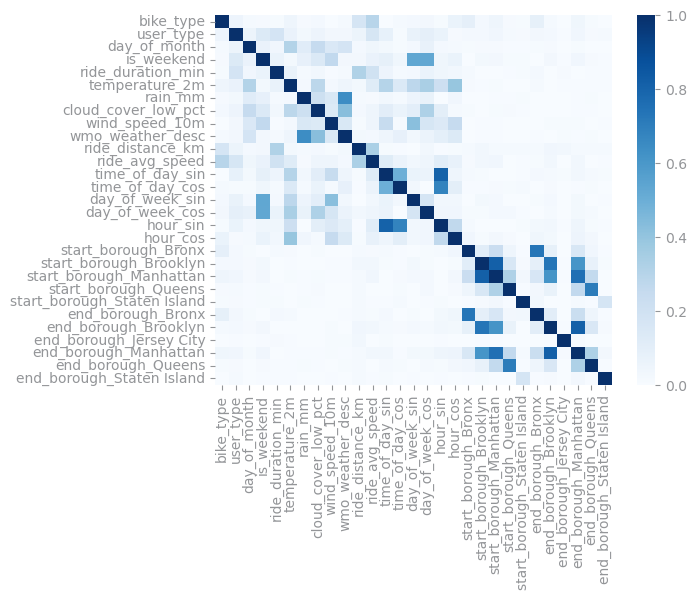

In [309]:
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show

variables_types: dict[str, list] = get_variable_types(df_enc)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = df_enc.corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=df_enc.columns,
    yticklabels=df_enc.columns,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
#savefig(f"images/{file_tag}_correlation_analysis.png")
show()

# Cluster Data Preparation
- To apply clustering thecniques we need to apply specific date preparation thecniques, like scaling, drop of outliers and also feature selection

## Outliers detection

In [310]:
def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(df_enc)
print(variable_types)

{'numeric': ['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos'], 'binary': ['bike_type', 'user_type', 'is_weekend', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Manhattan', 'start_borough_Queens', 'start_borough_Staten Island', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City', 'end_borough_Manhattan', 'end_borough_Queens', 'end_borough_Staten Island'], 'date': [], 'symbolic': [], 'id': []}


### 1 - Drop Outliers

In [311]:
numeric_vars = variable_types["numeric"]
numeric_vars

['day_of_month',
 'ride_duration_min',
 'temperature_2m',
 'rain_mm',
 'cloud_cover_low_pct',
 'wind_speed_10m',
 'wmo_weather_desc',
 'ride_distance_km',
 'ride_avg_speed',
 'time_of_day_sin',
 'time_of_day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'hour_sin',
 'hour_cos']

In [312]:
# Usar a função get_variable_types() para obter as variáveis numéricas

variable_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variable_types["numeric"]

In [244]:
numeric

['day_of_month',
 'hour',
 'ride_duration_min',
 'temperature_2m',
 'rain_mm',
 'cloud_cover_low_pct',
 'wind_speed_10m',
 'ride_distance_km',
 'ride_avg_speed']

- using nr_stdev=2

In [313]:
from pandas import DataFrame, Series


def apply_strategy_2(df: DataFrame, summary5: DataFrame, nr_stdev: float = 2) -> DataFrame:
    df_copy = df.copy()

    # Definindo as variáveis contínuas específicas que desejas monitorar


    # Filtrar apenas as variáveis contínuas que existem no DataFrame
    numeric_vars = [var for var in numeric if var in df_copy.columns]

    if numeric_vars:
        print(f"Data before dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)
        
        # Armazenar informações sobre os outliers
        outlier_info = {}

        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando o número de desvios padrão
            mean = summary5[var]['mean']
            std = summary5[var]['std']
            
            top = mean + nr_stdev * std
            bottom = mean - nr_stdev * std
            
            # Identificar os outliers
            outliers: Series = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]
            
            # Se houver outliers, armazenar as informações
            if not outliers.empty:
                outlier_info[var] = {
                    'outlier_indices': outliers.index.tolist(),
                    'outlier_count': outliers.shape[0],
                    'outlier_values': outliers[var].tolist()
                }

                # Remover outliers
                df_copy.drop(outliers.index, axis=0, inplace=True)
        
        print(f"Data after dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)

        # Imprimir informações sobre os outliers removidos apenas para as variáveis com outliers
        if outlier_info:
            for var, info in outlier_info.items():
                print(f"Variable '{var}':")
                print(f"  Number of outliers removed: {info['outlier_count']}")
                print(f"  Indices of outliers: {info['outlier_indices']}")
                print(f"  Values of outliers: {info['outlier_values']}")
                print()  # Linha em branco para melhor legibilidade
        else:
            print("No outliers were removed.")
    else:
        print("There are no numeric variables")

    return df_copy

# Usar a função
summary5 = df_enc.describe()  # Calcular o resumo estatístico apenas para as variáveis de interesse
nr_stdev = 2  # Exemplo, mas pode ser alterado para 3 ou outro valor

df_prep_outl_remov = apply_strategy_2(df_enc, summary5, nr_stdev)


Data before dropping outliers with nr_stdev=2: (22355, 29)
Data after dropping outliers with nr_stdev=2: (16199, 29)
Variable 'ride_duration_min':
  Number of outliers removed: 296
  Indices of outliers: [1923171, 1518583, 67966, 1899425, 1977649, 419793, 2624619, 2067992, 3046526, 519851, 2151837, 897453, 2672318, 2448343, 2399055, 1228203, 2508899, 2645063, 2654142, 2898172, 1072666, 3131066, 2883646, 2672277, 2936181, 139018, 3117109, 3052323, 1881502, 1131978, 586481, 1050920, 2222187, 2600842, 2877237, 1833273, 2339797, 2579349, 193744, 838534, 3041907, 2468554, 2214462, 1228576, 1775064, 1511683, 1398074, 1990497, 1798774, 2143326, 1618726, 1648394, 1866795, 2386771, 3070442, 1588458, 797486, 1864686, 2675308, 2222397, 2905574, 302190, 118109, 1761155, 109648, 2243914, 1871646, 1594793, 970839, 970046, 1944277, 2397248, 2696582, 683606, 1879317, 239208, 3042606, 2030900, 516755, 3079768, 2853602, 940218, 263377, 1771729, 2173830, 3145183, 2146235, 1243541, 1585866, 128796, 563100

In [314]:
display(df_prep_outl_remov.shape)
display(df_prep_outl_remov.columns)

(16199, 29)

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island'],
      dtype='object')

In [247]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl_remov.shape) # df after enconding and data prep outlier removal


(22355, 17)

(22355, 29)

(16051, 29)

In [213]:
df_enc.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
1956998,1,1,28,1,16.796000,19.5,0.0,0,15.9,3,...,0,1,0,0,0,0,0,1,0,0
1791342,1,0,28,1,21.585283,17.5,0.0,16,5.6,3,...,0,1,0,0,0,1,0,0,0,0
457396,1,1,23,0,6.859900,8.7,0.0,0,12.1,3,...,1,0,0,0,0,1,0,0,0,0
2783650,1,0,14,1,7.588267,19.4,0.0,0,20.3,3,...,0,1,0,0,0,0,0,1,0,0
3148647,1,0,25,0,7.562650,6.0,0.0,0,8.3,3,...,1,0,0,0,0,1,0,0,0,0


#### Check outliers after applying the strategy 1 

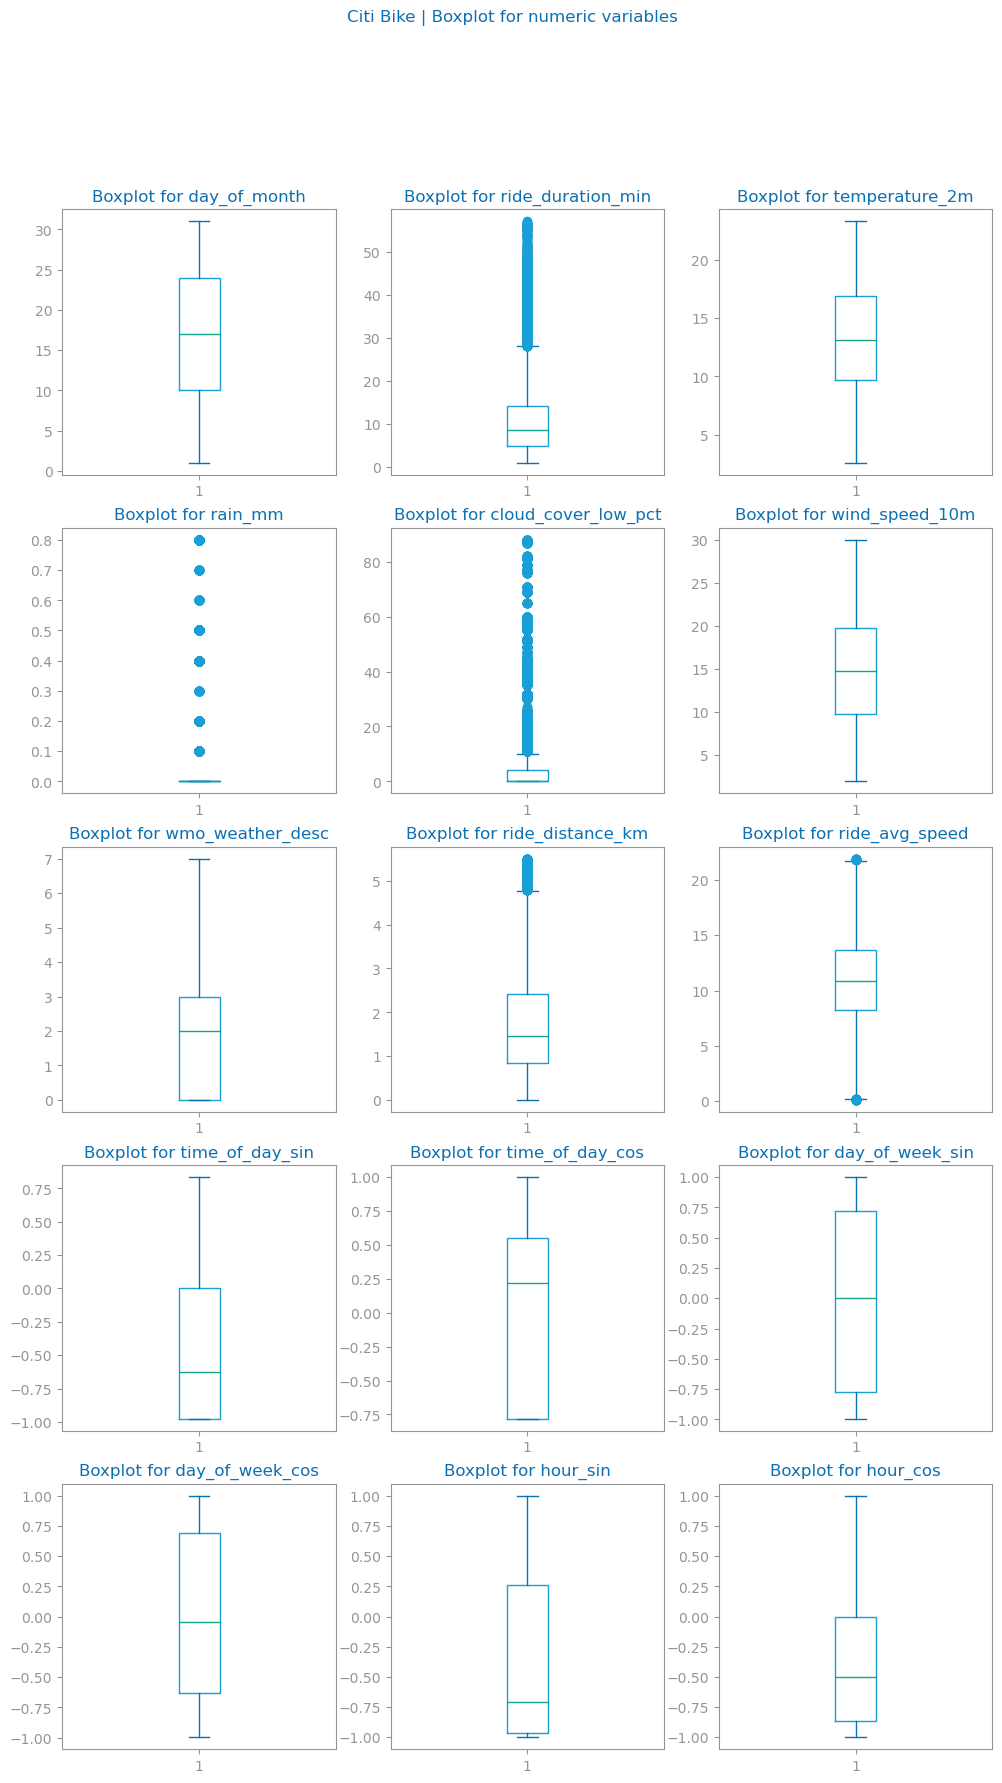

In [315]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_remov[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [218]:
display(df_prep_outl_remov['cloud_cover_low_pct'].value_counts())
display(df_prep_outl_remov['ride_duration_min'].value_counts())
display(df_prep_outl_remov['ride_distance_km'].value_counts())

cloud_cover_low_pct
0     9786
1      884
2      862
4      355
16     308
      ... 
90       7
81       6
36       5
43       1
27       1
Name: count, Length: 64, dtype: int64

ride_duration_min
4.321433     2
4.112083     2
5.019350     2
11.837950    2
4.956383     2
            ..
3.011433     1
18.158317    1
4.464950     1
14.142150    1
7.946300     1
Name: count, Length: 15940, dtype: int64

ride_distance_km
0.258034    7
0.247294    6
0.508479    4
0.570794    4
0.819852    4
           ..
2.137075    1
1.965161    1
1.827622    1
5.027967    1
2.194912    1
Name: count, Length: 15494, dtype: int64

#### Removing remaining outliers from vars: ride_distance_km, ride_duration_min, cloud_lower_cover_pct, rain_2_mm

In [316]:
df_prep_outl_remov_final = df_prep_outl_remov[
    (
    (df_prep_outl_remov['ride_duration_min'] <= 20)
    #& (df_prep_outl_remov['ride_avg_speed'] > 2)
    #& (df_prep_outl_remov['ride_avg_speed'] > 1)
    & (df_prep_outl_remov['ride_distance_km'] < 4)
    #& (df_prep_outl_remov['rain_mm'] >0.02)
    #& (df_prep_outl_remov['cloud_cover_low_pct'] < 1)
    )
]
display(df_enc.shape)
display(df_prep_outl_remov.shape)
display(df_prep_outl_remov_final.shape)

display(df_prep_outl_remov_final.head(5))

(22355, 29)

(16199, 29)

(13803, 29)

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
2424139,1,1,25,0,9.94790,6.6,0.0,0,11.8,2,...,0,1,0,0,0,0,0,1,0,0
2021408,1,1,28,1,9.73435,19.5,0.0,0,15.9,3,...,1,0,0,0,0,1,0,0,0,0
938575,0,1,24,0,9.51555,17.3,0.0,17,25.7,1,...,0,1,0,0,0,0,0,1,0,0
2066963,0,1,26,0,2.29280,13.0,0.0,1,18.4,2,...,0,0,1,0,0,1,0,0,0,0
757792,1,1,17,0,10.36730,12.0,0.4,21,16.2,6,...,0,1,0,0,0,0,0,1,0,0


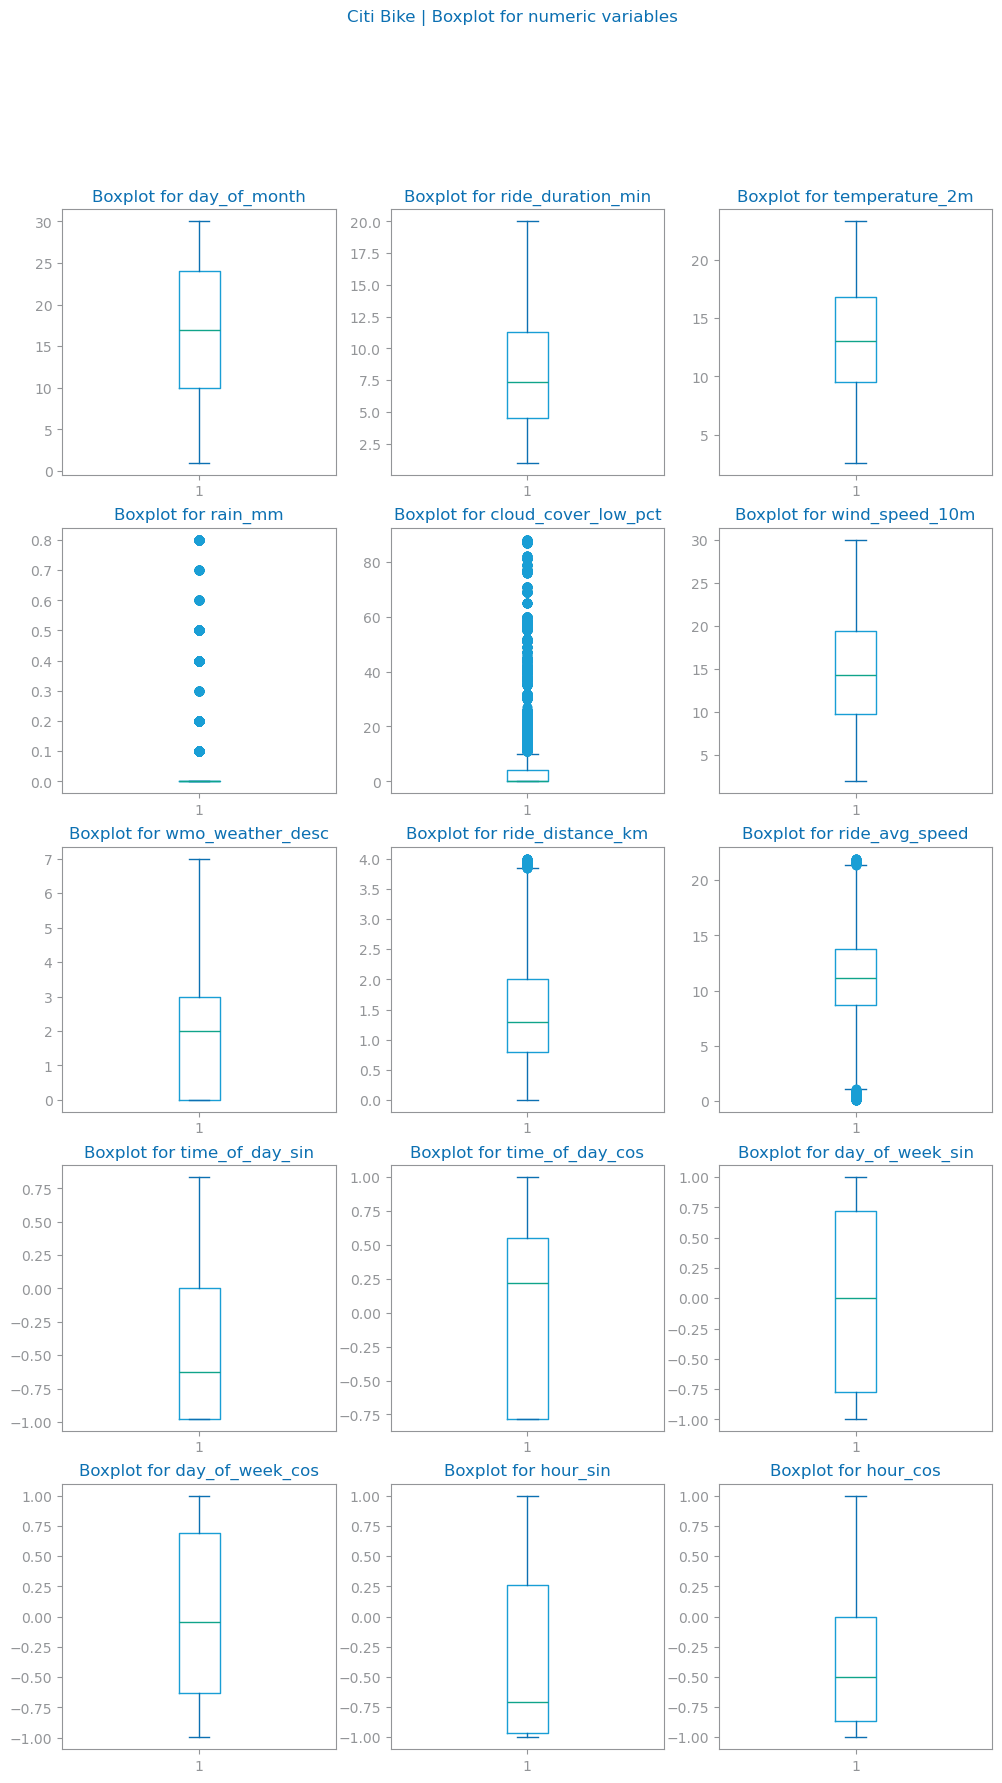

In [317]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_remov_final[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [270]:
display(df_prep_outl_remov['ride_distance_km'].value_counts())
display(df_prep_outl_remov['ride_avg_speed'].value_counts())
display(df_prep_outl_remov['rain_mm'].value_counts())
display(df_prep_outl_remov['cloud_cover_low_pct'].value_counts())



ride_distance_km
0.258034    7
0.247294    6
0.508479    4
0.570794    4
0.819852    4
           ..
2.137075    1
1.965161    1
1.827622    1
5.027967    1
2.194912    1
Name: count, Length: 15494, dtype: int64

ride_avg_speed
6.785961     1
9.205422     1
18.520557    1
9.355463     1
9.957998     1
            ..
10.575604    1
11.326399    1
14.468601    1
11.304676    1
16.573089    1
Name: count, Length: 16051, dtype: int64

rain_mm
0.0    15017
0.1      253
0.2      218
0.5      161
0.4      156
0.8      118
0.6       62
0.7       35
0.3       31
Name: count, dtype: int64

cloud_cover_low_pct
0     9786
1      884
2      862
4      355
16     308
      ... 
90       7
81       6
36       5
43       1
27       1
Name: count, Length: 64, dtype: int64

In [318]:
display(df_prep_outl_remov_final.shape)

(13803, 29)

### 2 - Truncate Outliers

In [319]:
from pandas import DataFrame
from dslabs_functions import (
    NR_STDEV,
    determine_outlier_thresholds_for_var
)

def apply_strategy_1(df: DataFrame, summary5: DataFrame, numeric_vars: list[str]) -> DataFrame:
    df_copy = df.copy()

    if numeric_vars:
        print("Data before truncating outliers:", df.shape)
        
        for var in numeric_vars:
            # Calculate the outlier thresholds for the variable using summary5
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            
            # Truncate outliers for each variable
            df_copy[var] = df_copy[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        
        print("Data after truncating outliers:", df_copy.shape)
    else:
        print("None of the specified continuous variables are in the dataset.")
    
    return df_copy


# Calculate the summary statistics before calling the function
summary5 = df_enc.describe()

# Call the function and pass the continuous variables
df_prep_outl_trunc = apply_strategy_1(df_enc, summary5, numeric_vars)


Data before truncating outliers: (22355, 29)
Data after truncating outliers: (22355, 29)


In [320]:
# Verificar quais colunas foram alteradas e coletar informações
altered_info = {}
# Definindo as variáveis contínuas que desejas monitorar

for var in numeric_vars:
    if var in df_enc.columns and var in df_prep_outl_trunc.columns:  # Verifica se a variável existe em ambos os DataFrames
        altered_indices = df_enc.index[df_enc[var] != df_prep_outl_trunc[var]].tolist()
        if altered_indices:
            altered_count = len(altered_indices)
            new_values = df_prep_outl_trunc.loc[altered_indices, var].to_list()
            altered_info[var] = {'altered_count': altered_count, 'new_values': new_values}

# Imprimir informações das colunas alteradas
for var, info in altered_info.items():
    print(f"Coluna '{var}' foi alterada. Número de linhas alteradas: {info['altered_count']}. Novos valores: {info['new_values']}")


Coluna 'ride_duration_min' foi alterada. Número de linhas alteradas: 296. Novos valores: [57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.332595634198654, 57.3325956

#### Check outliers after Outliers strategy is aplied

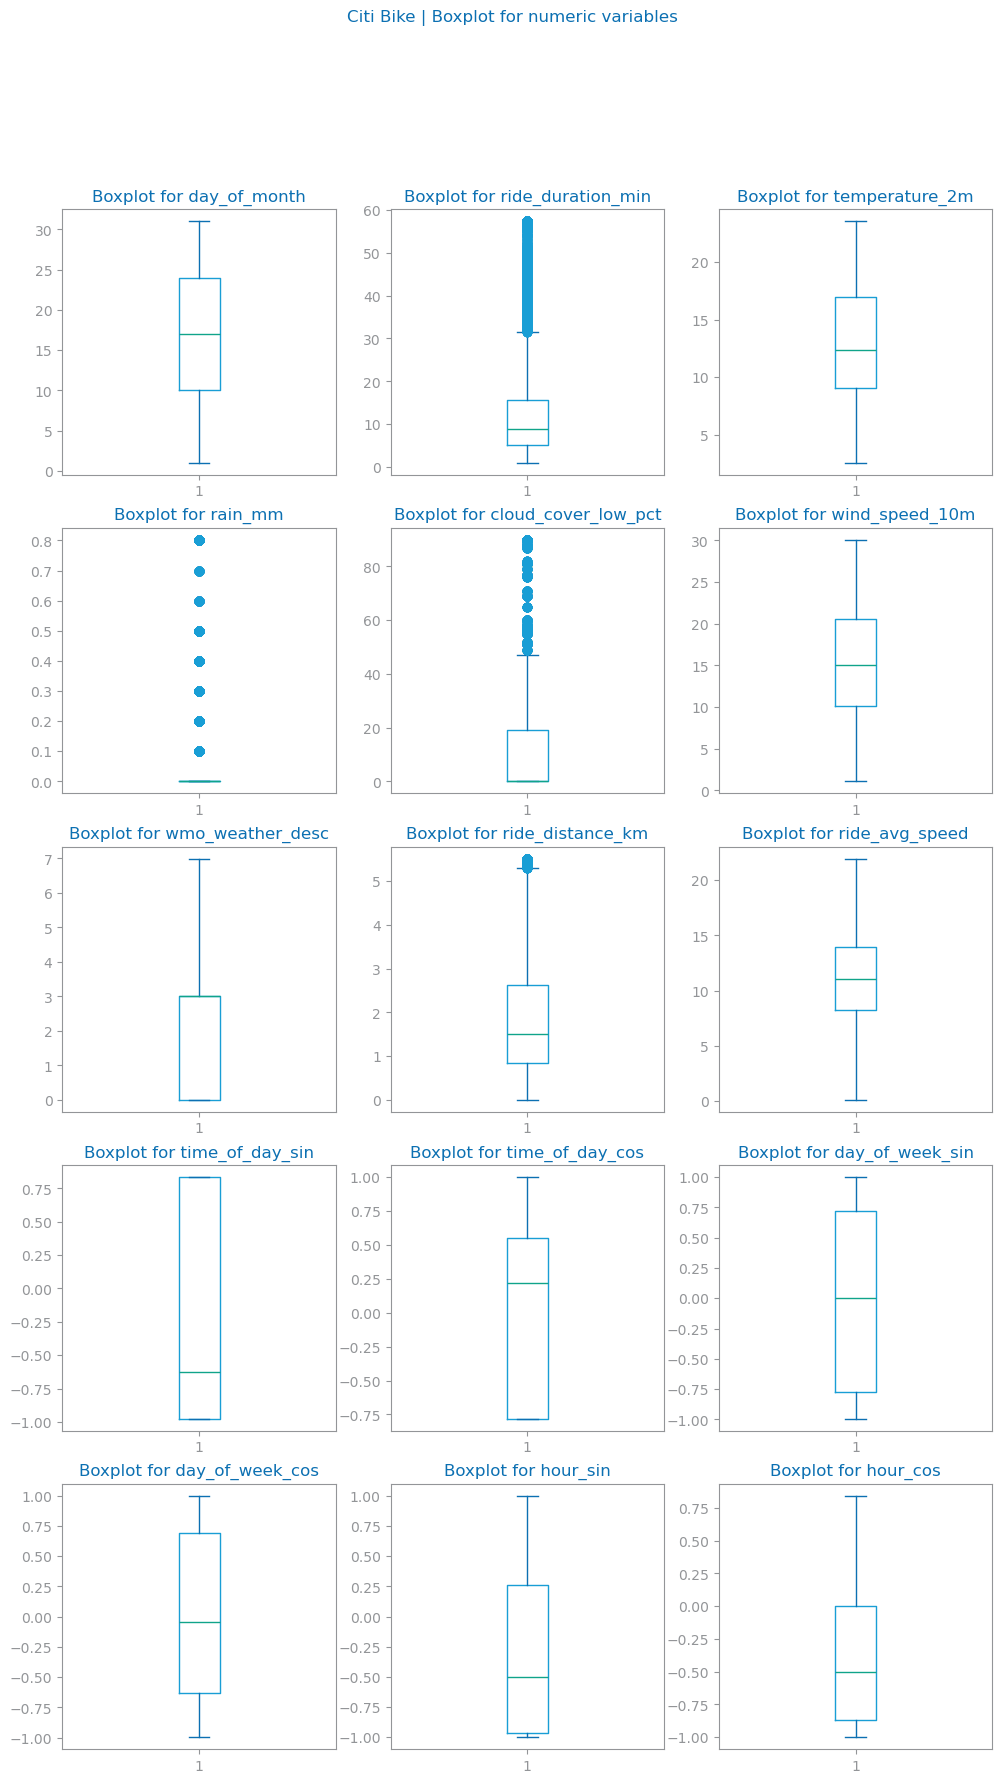

In [321]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_trunc[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [322]:
df_prep_outl_trunc.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
2509920,1,1,9,0,32.093883,14.6,0.0,0.000000,18.2,3.0,...,0,1,0,0,0,0,0,1,0,0
764500,0,1,30,0,5.470650,13.7,0.0,89.879222,13.2,3.0,...,0,1,0,0,0,0,0,1,0,0
585092,1,1,4,0,4.953583,3.5,0.0,89.879222,20.6,3.0,...,0,1,0,0,0,0,0,1,0,0
1609314,1,0,20,1,23.691217,15.6,0.0,0.000000,22.7,0.0,...,0,1,0,0,0,0,0,1,0,0
2424139,1,1,25,0,9.947900,6.6,0.0,0.000000,11.8,2.0,...,0,1,0,0,0,0,0,1,0,0


#### Removing remaining outliers from vars: ride_distance_km, ride_duration_min, cloud_lower_cover_pct, rain_2_mm

In [323]:
df_prep_outl_trunc_final = df_prep_outl_trunc[
    (
    (df_prep_outl_trunc['ride_duration_min'] <=21)
    & (df_prep_outl_trunc['ride_distance_km'] < 4)
    #& (df_prep_outl_trunc['rain_mm'] >0.09)
    #& (df_prep_outl_trunc['cloud_cover_low_pct'] >10)
    )
]
display(df_enc.shape)
display(df_prep_outl_trunc.shape)
display(df_prep_outl_trunc_final.shape)
display(df_prep_outl_trunc.head(5))

(22355, 29)

(22355, 29)

(18113, 29)

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
2509920,1,1,9,0,32.093883,14.6,0.0,0.000000,18.2,3.0,...,0,1,0,0,0,0,0,1,0,0
764500,0,1,30,0,5.470650,13.7,0.0,89.879222,13.2,3.0,...,0,1,0,0,0,0,0,1,0,0
585092,1,1,4,0,4.953583,3.5,0.0,89.879222,20.6,3.0,...,0,1,0,0,0,0,0,1,0,0
1609314,1,0,20,1,23.691217,15.6,0.0,0.000000,22.7,0.0,...,0,1,0,0,0,0,0,1,0,0
2424139,1,1,25,0,9.947900,6.6,0.0,0.000000,11.8,2.0,...,0,1,0,0,0,0,0,1,0,0


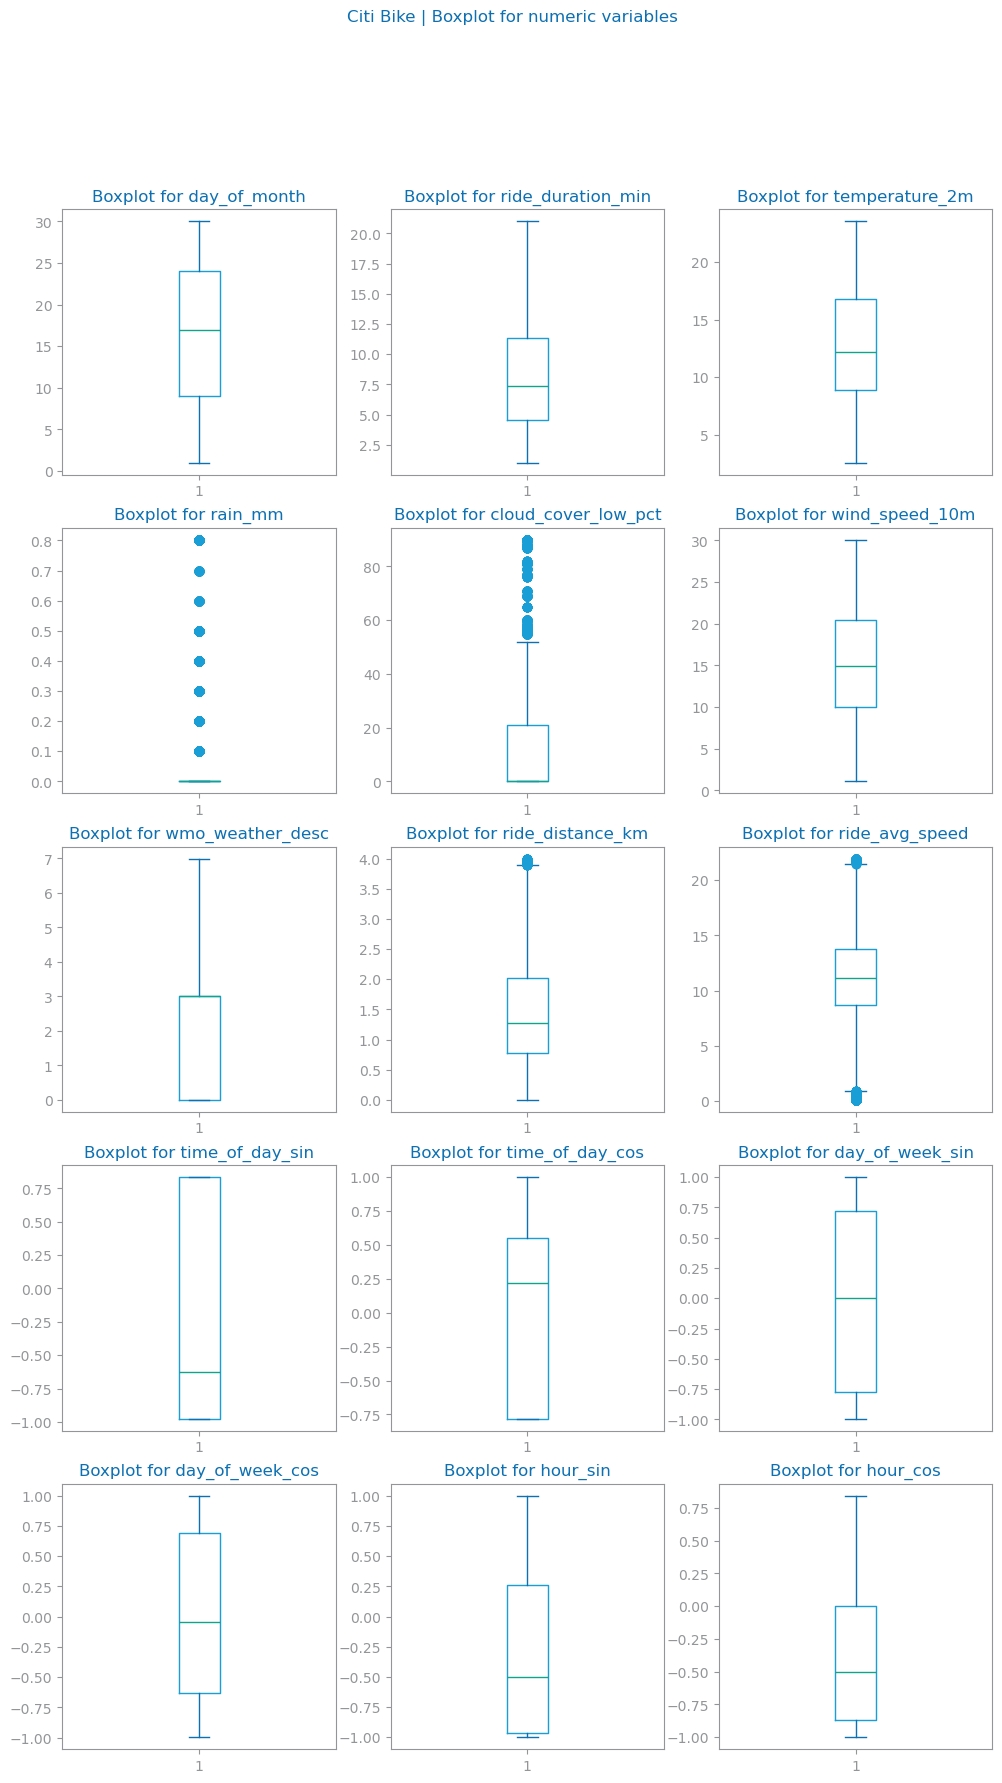

In [324]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_trunc_final[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [325]:
df_prep_outl_trunc_final.shape

(18113, 29)

## Scaling

### Scale strategy 1 - Standard Scaler

In [326]:
# Escolher o DataFrame a ser utilizado no scaling com base na variável 'use_df_scaling'
if use_df_in_scaling == "df_enc":
    df_to_use_scal = df_enc
elif use_df_in_scaling == "df_prep_outl_trunc_final":
    df_to_use_scal = df_prep_outl_trunc_final  # Presumo que df_prep_outl seja o outro DataFrame desejado
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_scaling}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the {use_df_in_scaling} dataset, which means that we are {'not ' if use_df_in_scaling == 'df_enc' else ''}considering the removal of outliers.")
print(f"Shape of dataset: {df_to_use_scal.shape}")


We will use the df_prep_outl_trunc_final dataset, which means that we are considering the removal of outliers.
Shape of dataset: (18113, 29)


In [327]:

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

def apply_standard_scaler(df: DataFrame) -> DataFrame:

    df_copy = df.copy()
    
    # Apply scaling to all the feature columns (since there is no target)
    transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_copy)
    df_zscore = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    return df_zscore

In [328]:

def apply_strategy_1(df):

    df_copy=df.copy()
    
    df_zscore=apply_standard_scaler(df_copy)

    return df_zscore

df_prep_scal=apply_strategy_1(df_to_use_scal)

df_prep_scal.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island'],
      dtype='object')

In [329]:
df_prep_scal.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18113 entries, 764500 to 536929
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bike_type                    18113 non-null  float64
 1   user_type                    18113 non-null  float64
 2   day_of_month                 18113 non-null  float64
 3   is_weekend                   18113 non-null  float64
 4   ride_duration_min            18113 non-null  float64
 5   temperature_2m               18113 non-null  float64
 6   rain_mm                      18113 non-null  float64
 7   cloud_cover_low_pct          18113 non-null  float64
 8   wind_speed_10m               18113 non-null  float64
 9   wmo_weather_desc             18113 non-null  float64
 10  ride_distance_km             18113 non-null  float64
 11  ride_avg_speed               18113 non-null  float64
 12  time_of_day_sin              18113 non-null  float64
 13  time_of_day_cos

In [330]:
df_prep_scal.shape

(18113, 29)

In [331]:
display(df_prep_scal['bike_type'].value_counts())
display(df_prep_scal['user_type'].value_counts())

bike_type
 0.735532    11754
-1.359560     6359
Name: count, dtype: int64

user_type
 0.428153    15307
-2.335615     2806
Name: count, dtype: int64

### Scale strategy 2 - MinMax Scaler


In [332]:
from sklearn.preprocessing import MinMaxScaler

def apply_min_max_scaler(df: DataFrame) -> DataFrame:

    df_copy=df.copy()
        # Apply MinMax scaling to the feature columns only
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_copy)
    df_minmax = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    return df_minmax

In [333]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler


def apply_strategy_2(df):

    df_copy=df.copy()
    
    # this script is available in data_functions originally from DSLabs site in Scaling chapter
    df_copy=apply_min_max_scaler(df)

    return df_copy

df_pre_scal_2=apply_strategy_2(df_to_use_scal)
df_pre_scal_2.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island'],
      dtype='object')

In [334]:
df_pre_scal_2.shape

(18113, 29)

#### scaling plot - visualize oth streategies

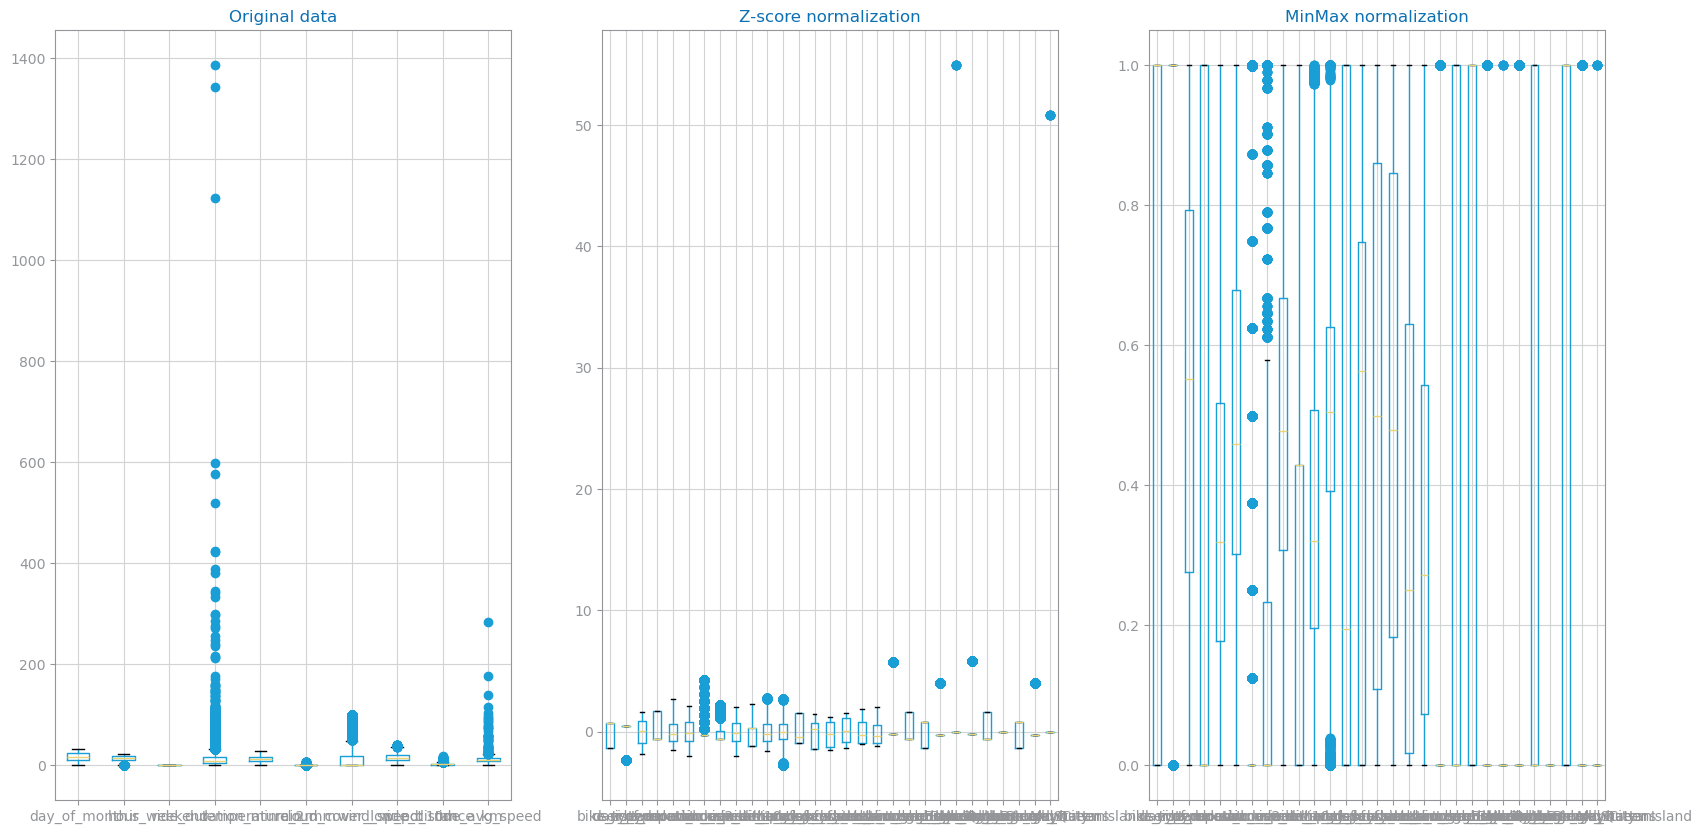

In [335]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 0].set_title("Original data")
df.boxplot(ax=axs[0, 0])
axs[0, 1].set_title("Z-score normalization")
df_prep_scal.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_pre_scal_2.boxplot(ax=axs[0, 2])
show()

### Analysis insights

- Let's proceed with the dataste df_prep_scal, where we applied standard scaling

In [363]:
display(df_prep_scal[df_prep_scal.gt(50).any(axis=1)])

display((df_prep_scal.gt(50).any(axis=1)).sum())

display((df_prep_scal.max() > 50))

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
269713,-1.359560,-2.335615,1.021932,-0.587870,1.403277,-0.966433,-0.320489,-0.598856,-0.005886,-1.182452,...,-0.621762,-1.313076,-0.249067,54.934810,-0.172771,-0.616387,0.0,-1.324067,-0.249317,50.858347
1252311,0.735532,-2.335615,-1.267614,1.701057,1.756702,-0.848226,-0.320489,0.572889,0.093022,-0.202273,...,-0.621762,0.761570,-0.249067,-0.018203,-0.172771,-0.616387,0.0,-1.324067,-0.249317,50.858347
1272165,0.735532,-2.335615,-1.870127,-0.587870,0.860862,-1.399861,0.823814,-0.598856,-1.206904,1.758083,...,-0.621762,0.761570,-0.249067,-0.018203,-0.172771,-0.616387,0.0,-1.324067,-0.249317,50.858347
2025917,-1.359560,-2.335615,-1.147112,1.701057,1.804424,-0.493603,-0.320489,-0.598856,-0.472163,-1.182452,...,-0.621762,-1.313076,-0.249067,54.934810,5.788001,-0.616387,0.0,-1.324067,-0.249317,-0.019662
1237746,0.735532,0.428153,0.419420,1.701057,0.709745,0.964291,-0.320489,-0.598856,1.025577,-0.692362,...,-0.621762,0.761570,-0.249067,-0.018203,-0.172771,-0.616387,0.0,-1.324067,-0.249317,50.858347
1277494,0.735532,0.428153,-0.544600,-0.587870,1.395230,0.983992,1.968117,2.172605,1.209262,1.758083,...,-0.621762,0.761570,-0.249067,-0.018203,-0.172771,-0.616387,0.0,-1.324067,-0.249317,50.858347
1273260,0.735532,0.428153,-0.062590,-0.587870,0.724218,0.136838,-0.320489,-0.598856,0.234318,-1.182452,...,-0.621762,0.761570,-0.249067,-0.018203,-0.172771,-0.616387,0.0,-1.324067,-0.249317,50.858347
1094404,0.735532,0.428153,-0.906107,-0.587870,1.783607,1.141602,-0.320489,-0.598856,0.022374,0.287816,...,-0.621762,-1.313076,-0.249067,54.934810,-0.172771,-0.616387,0.0,0.755249,-0.249317,-0.019662
906366,-1.359560,0.428153,0.419420,1.701057,-1.314740,-0.749719,4.264590,2.172605,-0.980830,2.245193,...,-0.621762,-1.313076,-0.249067,54.934810,-0.172771,1.622357,0.0,-1.324067,-0.249317,-0.019662
1729719,0.735532,-2.335615,1.383440,1.701057,0.041458,0.806681,-0.320489,-0.598856,-1.136256,0.287816,...,-0.621762,-1.313076,-0.249067,54.934810,5.788001,-0.616387,0.0,-1.324067,-0.249317,-0.019662


12

bike_type                      False
user_type                      False
day_of_month                   False
is_weekend                     False
ride_duration_min              False
temperature_2m                 False
rain_mm                        False
cloud_cover_low_pct            False
wind_speed_10m                 False
wmo_weather_desc               False
ride_distance_km               False
ride_avg_speed                 False
time_of_day_sin                False
time_of_day_cos                False
day_of_week_sin                False
day_of_week_cos                False
hour_sin                       False
hour_cos                       False
start_borough_Bronx            False
start_borough_Brooklyn         False
start_borough_Manhattan        False
start_borough_Queens           False
start_borough_Staten Island     True
end_borough_Bronx              False
end_borough_Brooklyn           False
end_borough_Jersey City        False
end_borough_Manhattan          False
e

## Feature selection

### Feat 2 - Variance Threshold (Remove Low-Variance Features)


In [336]:

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_feat_eng' (feature engineering)
if use_df_in_feat_eng == "df_enc":
    df_to_use_feat = df_enc
elif use_df_in_feat_eng == "df_prep_outl":
    df_to_use_feat = df_prep_outl_trunc_final
elif use_df_in_feat_eng == "df_prep_scal":
    df_to_use_feat = df_prep_scal
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_feat_eng}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_feat_eng} dataset, which means that we are {'not ' if use_df_in_feat_eng == 'df_enc' else ''}considering the removal of outliers and also scaled data")
print(f"Shape of dataset: {df_to_use_feat.shape}")


We will use the dataset df_prep_scal dataset, which means that we are considering the removal of outliers and also scaled data
Shape of dataset: (18113, 29)


In [337]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl_trunc_final.shape) # df after enconding and data prep outlier removal
display(df_prep_scal.shape) 

(22355, 17)

(22355, 29)

(18113, 29)

(18113, 29)

In [338]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.1)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
selected_features = df_to_use_feat.columns[selector.get_support()]
print(selected_features)

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island'],
      dtype='object')


In [345]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


# Print initial features
print("Initial features:\n", df_to_use_feat.columns.tolist())

# Compute variance for each feature
feature_variance = df_to_use_feat.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
initial_features = list(set(df_to_use_feat.columns))
removed_features = list(set(df_to_use_feat.columns) - set(selected_features))
selected_features = df_to_use_feat.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


Initial features:
 ['bike_type', 'user_type', 'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Manhattan', 'start_borough_Queens', 'start_borough_Staten Island', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City', 'end_borough_Manhattan', 'end_borough_Queens', 'end_borough_Staten Island']

Feature Variance:
 bike_type                      1.000055
user_type                      1.000055
day_of_month                   1.000055
is_weekend                     1.000055
ride_duration_min              1.000055
temperature_2m                 1.000055
rain_mm                        1.000055
cloud_cover_low_pct            1.000055
wind_speed_10m                 1.000055
wmo_weather_desc

In [346]:
df_prep_feat_var = df_to_use_feat[selected_features]

In [347]:
df_prep_feat_var.shape

(18113, 28)

### Feat 3 - Drop Redundant Variables
    - Correlation interpretation - values between [-1,1]:
        - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
        - 0.7 to 0.9: Strong correlation.
        - 0.3 to 0.7: Moderate correlation.
        - 0.1 to 0.3: Weak correlation.
        - 0 to 0.1: No significant correlation.       

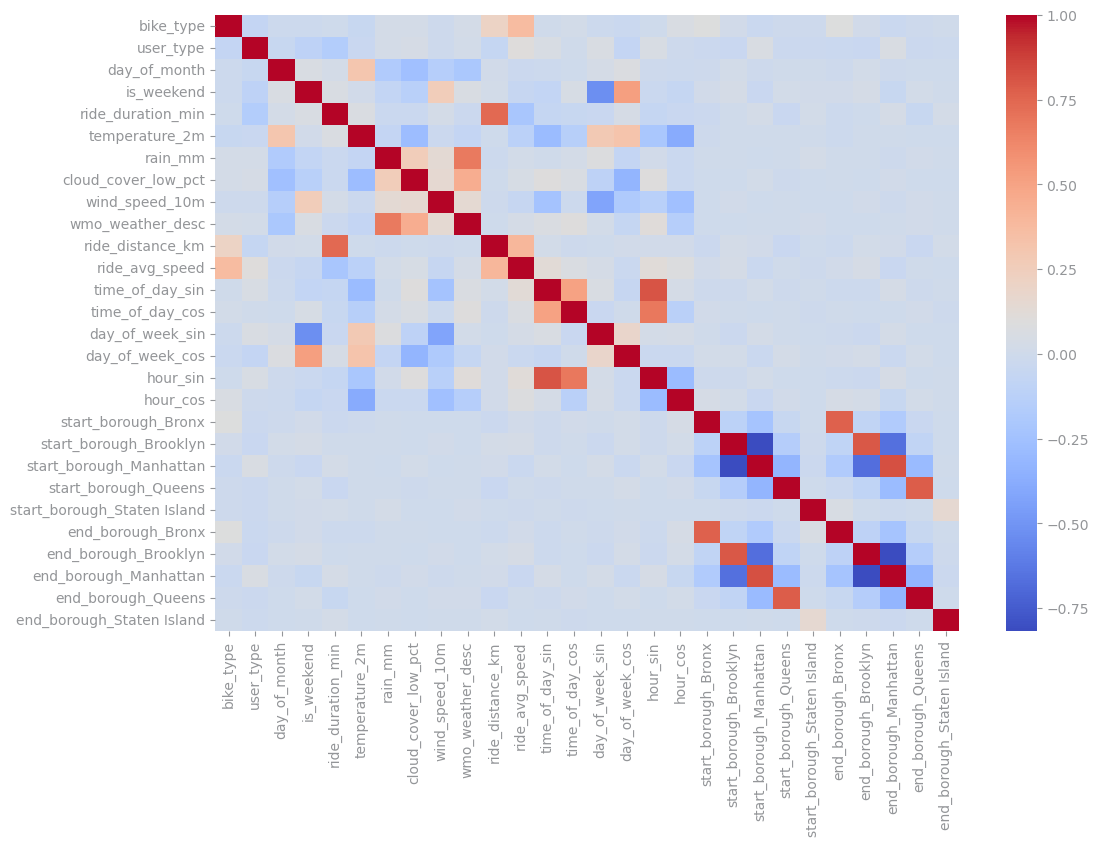

In [348]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [350]:
import numpy as np

# Calculate correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] > 0.7:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(df_prep_feat_var.columns)}")

# Print redundant pairs
print(f"Redundant pairs (correlation > 0.7):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features dropped: {to_drop}")

# Drop the correlated features
df_prep_feat = df_prep_feat_var.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(df_prep_feat.columns)}")
print(f"Remaining features: {df_prep_feat.columns.tolist()}")


Initial number of features: 28
Redundant pairs (correlation > 0.7):
ride_duration_min and ride_distance_km: Correlation = 0.7430063639338096
time_of_day_sin and hour_sin: Correlation = 0.8112292879584428
start_borough_Bronx and end_borough_Bronx: Correlation = 0.7726282249528321
start_borough_Brooklyn and end_borough_Brooklyn: Correlation = 0.7953772974675728
start_borough_Manhattan and end_borough_Manhattan: Correlation = 0.8233178267104434
start_borough_Queens and end_borough_Queens: Correlation = 0.7863775243664993
Number of features dropped: 6
Features dropped: ['ride_distance_km', 'hour_sin', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens']
Remaining features: 22
Remaining features: ['bike_type', 'user_type', 'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc', 'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos'

In [352]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl_trunc_final.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 
display(df_prep_feat.shape) 

(22355, 17)

(22355, 29)

(18113, 29)

(18113, 28)

(18113, 22)

# Cluster Application Techinques 

In [353]:

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_clust' (clustering)
if use_df_in_clust == "df_enc":
    df_to_use_clust = df_enc
elif use_df_in_clust == "df_prep_outl":
    df_to_use_clust = df_prep_outl_trunc_final
elif use_df_in_clust == "df_prep_scal":
    df_to_use_clust = df_prep_scal
elif use_df_in_clust == "df_prep_feat":
    df_to_use_clust = df_prep_feat
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_clust}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_clust} dataset, which means that we are {'not ' if use_df_in_clust == 'df_enc' else ''}considering the removal of outliers and also scaled data, and also removal of non relevant features")
print(f"Shape of dataset: {df_to_use_clust.shape}")

We will use the dataset df_prep_feat dataset, which means that we are considering the removal of outliers and also scaled data, and also removal of non relevant features
Shape of dataset: (18113, 22)


In [354]:
df_to_use_clust.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_cos,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Staten Island
764500,-1.359560,0.428153,1.624445,-0.587870,-0.601107,0.176240,-0.320489,2.172605,-0.316737,0.287816,...,0.732556,1.197680,0.020151,-0.330469,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662
585092,0.735532,0.428153,-1.508619,-0.587870,-0.711619,-1.833289,-0.320489,2.172605,0.728855,0.287816,...,0.732556,-0.296625,-1.393911,-0.330469,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662
2424139,0.735532,0.428153,1.021932,-0.587870,0.355810,-1.222550,-0.320489,-0.598856,-0.514552,-0.202273,...,-1.420707,-0.296625,-1.393911,1.006660,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662
2021408,0.735532,0.428153,1.383440,1.701057,0.310168,1.318914,-0.320489,-0.598856,0.064762,0.287816,...,0.199090,-0.184553,1.559941,-0.330469,-0.174459,1.608332,-1.313076,-0.249067,-0.018203,-0.019662
938575,-1.359560,0.428153,0.901430,-0.587870,0.263404,0.885486,-0.320489,-0.074655,1.449466,-0.692362,...,-1.420707,0.732785,-1.027083,0.094100,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662


In [355]:
df_to_use_clust.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_avg_speed',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_cos', 'start_borough_Bronx',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Staten Island'],
      dtype='object')

## K means Clustering

### Elbow method study

In [356]:
df_to_use_clust.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_cos,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Staten Island
764500,-1.359560,0.428153,1.624445,-0.587870,-0.601107,0.176240,-0.320489,2.172605,-0.316737,0.287816,...,0.732556,1.197680,0.020151,-0.330469,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662
585092,0.735532,0.428153,-1.508619,-0.587870,-0.711619,-1.833289,-0.320489,2.172605,0.728855,0.287816,...,0.732556,-0.296625,-1.393911,-0.330469,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662
2424139,0.735532,0.428153,1.021932,-0.587870,0.355810,-1.222550,-0.320489,-0.598856,-0.514552,-0.202273,...,-1.420707,-0.296625,-1.393911,1.006660,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662
2021408,0.735532,0.428153,1.383440,1.701057,0.310168,1.318914,-0.320489,-0.598856,0.064762,0.287816,...,0.199090,-0.184553,1.559941,-0.330469,-0.174459,1.608332,-1.313076,-0.249067,-0.018203,-0.019662
938575,-1.359560,0.428153,0.901430,-0.587870,0.263404,0.885486,-0.320489,-0.074655,1.449466,-0.692362,...,-1.420707,0.732785,-1.027083,0.094100,-0.174459,-0.621762,0.761570,-0.249067,-0.018203,-0.019662


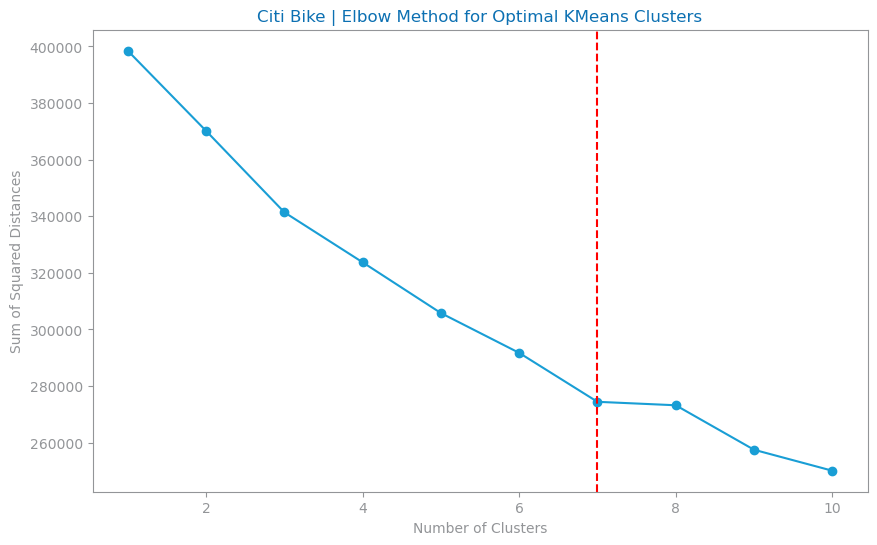

In [357]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_to_use_clust)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

## Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()


In [358]:
print(f"Elbow Point: {elbow_point}")


Elbow Point: 7


### Sillhouete study for kmeans

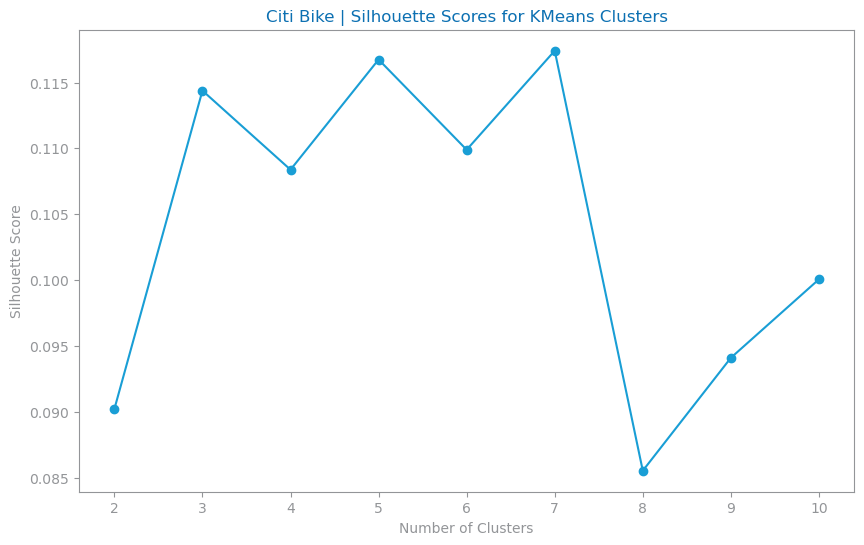

In [359]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_to_use_clust)
    silhouette_avg = silhouette_score(df_to_use_clust, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Kmeans model

In [360]:
# Clustering
citibike_kmeans = KMeans(n_clusters=7, random_state=42)
citibike_y_pred_kmeans = citibike_kmeans.fit_predict(df_to_use_clust)

citibike_kmeans.cluster_centers_

array([[-3.71595497e-02,  1.42889337e-01,  2.58304376e-02,
        -5.84925898e-01, -6.66178174e-02, -3.54937749e-01,
        -2.71920489e-01, -6.30210150e-03, -4.32557380e-01,
        -1.75483963e-01,  1.30400081e-01,  1.24313386e+00,
         9.06196912e-01,  3.41488509e-01, -3.18079568e-01,
         1.03769242e-01, -1.74458511e-01, -6.21762071e-01,
         7.61570438e-01, -2.49067449e-01, -1.82033942e-02,
        -3.30296745e-03],
       [ 2.24832075e-02, -1.89573601e-03,  4.82479529e-02,
        -5.85119568e-01, -4.47293070e-02,  1.35217849e-02,
        -2.72709428e-01, -1.27514649e-02, -1.95659144e-01,
        -2.62043946e-01,  9.40477506e-02,  1.64125582e-02,
        -5.35188461e-02,  2.63493442e-01, -2.93158497e-01,
         7.95655925e-02, -1.74458511e-01,  1.60833226e+00,
        -1.31307618e+00, -2.49067449e-01, -1.82033942e-02,
        -4.37918492e-03],
       [-1.63849117e-02,  6.57385640e-02,  2.58338678e-02,
        -5.87869855e-01,  4.22501792e-02,  2.62835114e-01,
    

## Hierarchical Clustering - Agglomerative

### Sillouette Study for Agglomerative

In [361]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def evaluate_agglomerative_clustering(X, 
                                      n_clusters_list=[2, 3, 4, 5,6,7,8,9,10], 
                                      metric_list=['euclidean', 'manhattan', 'cosine'], 
                                      linkage_list=['ward', 'complete', 'average', 'single'],
                                      scale='no',
                                      title='Silhouette Scores for Different Clustering Parameters'):
    # Scale the data if required
    if scale == 'yes':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Store the results
    results = []

    for n_clusters in n_clusters_list:
        for metric in metric_list:
            for linkage in linkage_list:
                if linkage == 'ward' and metric != 'euclidean':
                    continue  # Ward linkage only works with Euclidean distance
                clustering = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
                labels = clustering.fit_predict(X)
                score = silhouette_score(X, labels)
                results.append((n_clusters, metric, linkage, score))

    # Convert results to a structured array for easy plotting
    dtype = [('n_clusters', int), ('metric', 'U10'), ('linkage', 'U10'), ('score', float)]
    results = np.array(results, dtype=dtype)

    # Plot the results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    
    for ax, linkage in zip(axes, linkage_list):
        for metric in metric_list:
            subset = results[(results['metric'] == metric) & (results['linkage'] == linkage)]
            ax.plot(subset['n_clusters'], subset['score'], label=f'{metric}')
            for (n_clusters, score) in zip(subset['n_clusters'], subset['score']):
                ax.text(n_clusters, score, f'{score:.2f}', fontsize=8, ha='right')
        
        ax.set_title(f'Linkage: {linkage}')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Silhouette Score')
        ax.legend(loc='upper right')
        ax.set_xticks(n_clusters_list)
        ax.set_xticklabels([str(n) for n in n_clusters_list])
    
    fig.suptitle(title, fontsize=16)
    plt.show()

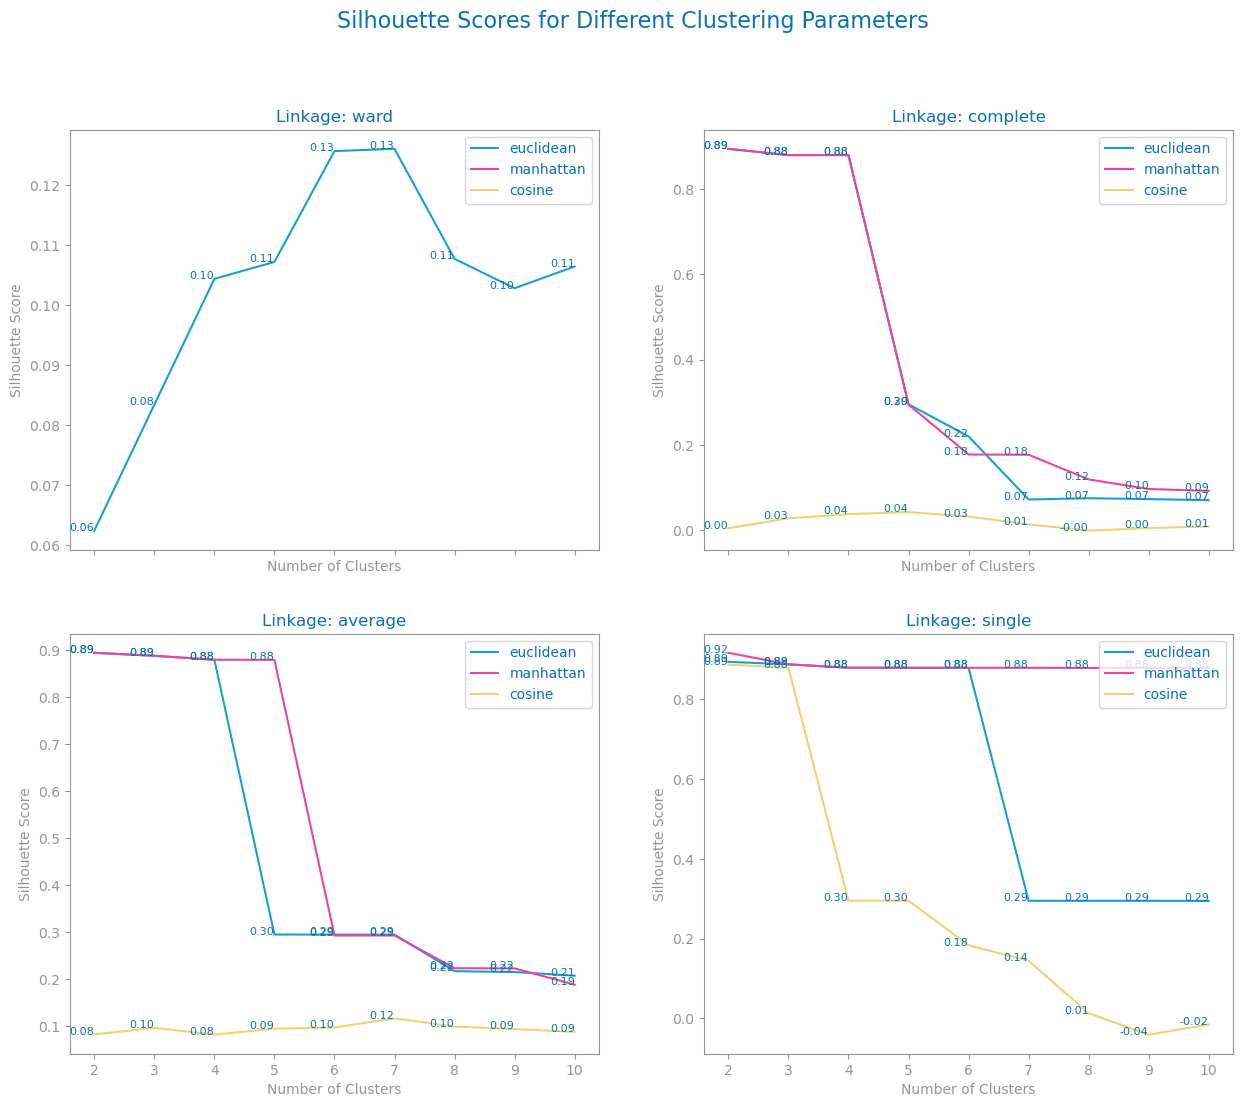

In [362]:
# available in data functions py

evaluate_agglomerative_clustering(df_to_use_clust, n_clusters_list=[2, 3, 4, 5,6,7,8,9,10], scale='no')

### Dendrogram

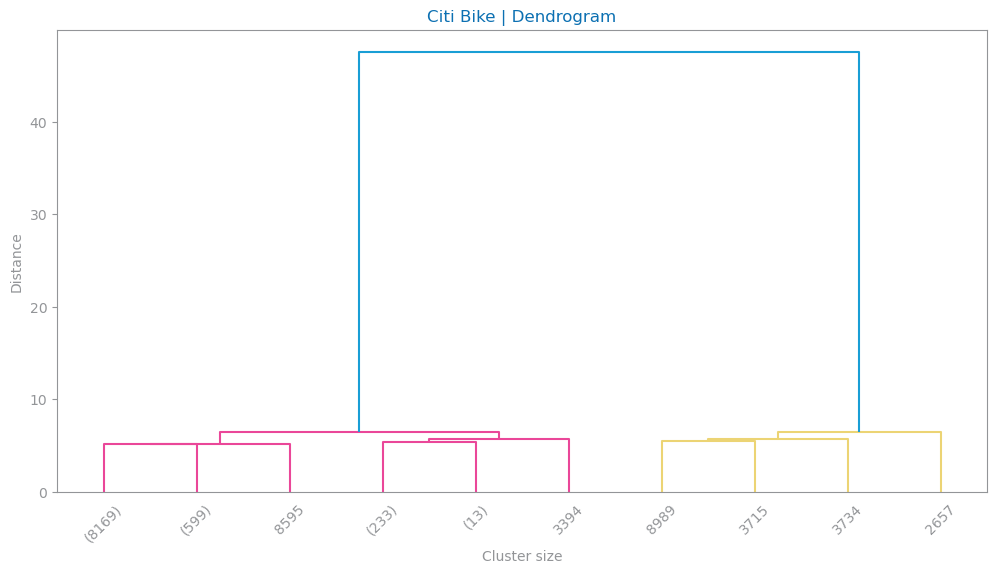

In [519]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(df_to_use_clust, method='single', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


### Agglomerative Model

In [553]:
from sklearn.cluster import AgglomerativeClustering

citibike_agglo = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='complete' )
citibike_y_pred_agglo = citibike_agglo.fit_predict(df_to_use_clust)

citibike_y_pred_agglo

array([1, 2, 2, ..., 1, 2, 2])

## DBSCAN Clustering - density-based

In [383]:
df_to_use_clust.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_Jersey City,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,kmeans_cluster,agglo_cluster,cluster
2275592,0.749091,0.485502,1.587598,-0.659940,-0.231809,1.388599,-0.209668,-0.309892,-0.532121,0.064925,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0,-1
1041224,0.749091,-2.059723,0.344719,1.515289,2.271978,0.994829,-0.209668,-0.309892,-0.442361,1.314548,...,-0.0146,-0.02921,1.422733,-0.212654,-0.331871,-0.874968,-0.293661,0,0,-1
196201,0.749091,0.485502,0.966158,-0.659940,-1.046750,-1.492139,-0.209668,-0.439330,-0.980918,-1.180854,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,1,0,-1
2253083,-1.334951,0.485502,0.220431,-0.659940,-0.599747,-0.186481,-0.209668,-0.309892,0.724511,-0.623092,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0,-1
2539636,0.749091,0.485502,0.469007,1.515289,-0.600775,-1.637212,-0.209668,-0.439330,-0.891159,-0.049651,...,-0.0146,-0.02921,-0.702872,-0.212654,-0.331871,1.142899,-0.293661,0,0,-1


In [384]:
df_to_use_clust.shape

(9384, 31)

Clusters identificados: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, -1}


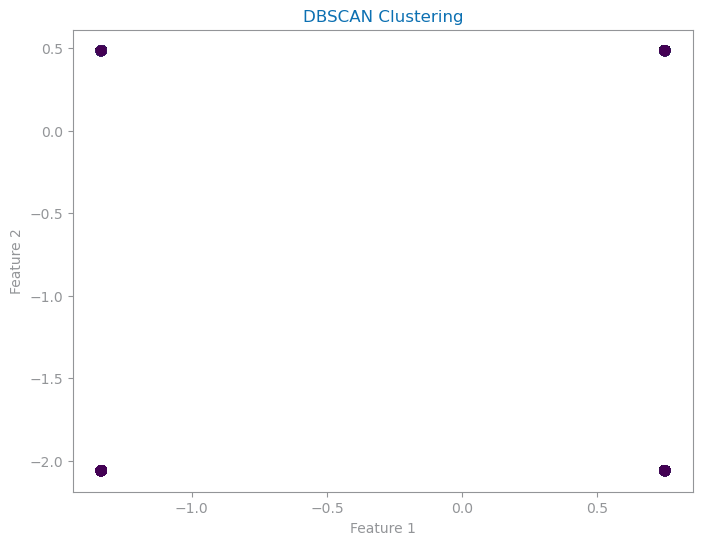

In [387]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Tentar valores diferentes para eps e min_samples
eps = 2        # Aumente este valor para aumentar a distância máxima entre pontos no mesmo cluster
min_samples = 10  # Experimente diminuir este valor para formar clusters menores

# Aplicar DBSCAN ao DataFrame
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_to_use_clust['cluster'] = dbscan.fit_predict(df_to_use_clust)

# Exibir os resultados
print("Clusters identificados:", set(df_to_use_clust['cluster']))

# Plotar os resultados
plt.figure(figsize=(8, 6))
plt.scatter(df_to_use_clust.iloc[:, 0], df_to_use_clust.iloc[:, 1], c=df_to_use_clust['cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



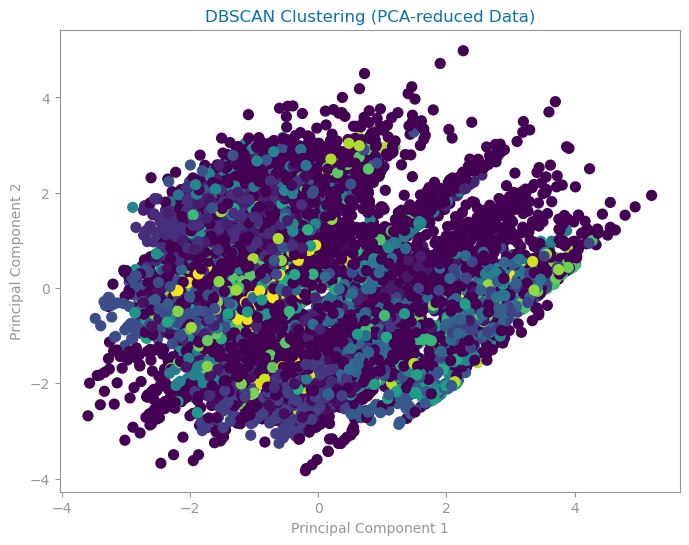

In [395]:
from sklearn.decomposition import PCA

# Aplicar PCA para reduzir as dimensões para 2
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_to_use_clust.drop('cluster', axis=1))  # Excluindo a coluna 'cluster' para aplicar o PCA

# Plotar os clusters em 2D após a redução de dimensionalidade
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_to_use_clust['cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering (PCA-reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Clustering approaches Evaluation

In [554]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(df_to_use_clust, citibike_y_pred_kmeans)
silhouette_agglo = silhouette_score(df_to_use_clust, citibike_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.13148031888706124
Silhouette Score for Agglomerative Clustering: 0.27166511817782585


## Cluster Labeling

In [555]:
# Add cluster labels to the dataframe
df_to_use_clust['kmeans_cluster'] = citibike_y_pred_kmeans
df_to_use_clust['agglo_cluster'] = citibike_y_pred_agglo

# Display the dataframe with the new cluster labels
df_to_use_clust.head(20)

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_avg_speed,...,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,kmeans_cluster,agglo_cluster
251838,-1.329556,0.445368,0.467472,1.560830,-0.169907,-1.640321,-0.224564,-0.458770,-0.872907,-1.346951,...,-1.289926,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,2,1
2326558,0.752131,-2.245335,0.716063,-0.640685,1.444772,-0.443817,-0.224564,-0.458770,1.870939,-0.129831,...,-1.289926,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,3,2
52894,0.752131,0.445368,1.213245,1.560830,-0.783378,0.092546,-0.224564,0.154419,1.826444,-0.513381,...,0.775238,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,2,2
2411156,0.752131,0.445368,-1.396960,1.560830,0.168062,-1.330880,-0.224564,-0.274813,-0.531780,0.632587,...,0.775238,-0.248095,-0.021063,-0.706813,-0.221267,3.106340,-0.838170,-0.318344,3,2
133610,0.752131,0.445368,-1.024074,-0.640685,-0.982952,-0.794517,-0.224564,-0.458770,-0.858075,1.248252,...,0.775238,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,3,2
1533300,0.752131,0.445368,1.586132,-0.640685,1.045591,0.463875,-0.224564,0.338376,-0.235148,0.486270,...,0.775238,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,3,2
2451037,0.752131,0.445368,0.964654,-0.640685,-0.604964,-1.495915,-0.224564,-0.458770,-0.961897,0.681553,...,0.775238,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,3,2
1783226,0.752131,-2.245335,0.591768,-0.640685,-0.243421,0.319469,-0.224564,-0.458770,-0.116495,-0.269820,...,-1.289926,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,2
2845498,0.752131,0.445368,-1.521255,-0.640685,0.108721,-1.640321,-0.224564,-0.458770,0.194968,1.085558,...,0.775238,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,2
530056,-1.329556,0.445368,0.964654,-0.640685,-0.631908,-1.351510,-0.224564,-0.458770,0.269126,-0.747302,...,-1.289926,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,-0.838170,3.141253,3,2


In [416]:
df_to_use_clust.shape

(9384, 31)

###  Cluster Counts

In [556]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = df_to_use_clust.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = df_to_use_clust.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0     616
1    2868
2    1999
3    3537
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0     603
1     233
2    8180
3       4
dtype: int64


In [557]:
agglo_weird_cluster = df_to_use_clust[df_to_use_clust['agglo_cluster']==1]

agglo_weird_cluster

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_avg_speed,...,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,kmeans_cluster,agglo_cluster
251838,-1.329556,0.445368,0.467472,1.560830,-0.169907,-1.640321,-0.224564,-0.458770,-0.872907,-1.346951,...,-1.289926,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,2,1
265969,0.752131,0.445368,-0.278301,-0.640685,0.312711,0.236952,-0.224564,-0.458770,1.144190,-2.035972,...,-1.289926,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,1
2863535,0.752131,0.445368,-0.154005,-0.640685,-0.071215,0.051288,-0.224564,-0.458770,0.343284,0.732863,...,-1.289926,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,1
2329442,0.752131,0.445368,-0.526892,1.560830,0.403523,-0.794517,-0.224564,-0.274813,1.322170,0.727799,...,-1.289926,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,1
1929603,0.752131,0.445368,-1.521255,-0.640685,-1.115334,-1.640321,-0.224564,-0.458770,0.194968,-1.542479,...,-1.289926,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697572,0.752131,0.445368,-1.396960,1.560830,-0.984764,-0.650111,-0.224564,2.729812,1.930265,-0.252488,...,-1.289926,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,1.193075,-0.318344,2,1
648283,0.752131,-2.245335,-1.396960,1.560830,-0.955909,-1.660950,-0.224564,0.706289,0.966211,1.071502,...,-1.289926,-0.248095,-0.021063,-0.706813,-0.221267,-0.321922,-0.838170,3.141253,2,1
2586521,0.752131,0.445368,0.964654,-0.640685,0.102597,-0.732629,-0.224564,-0.458770,0.061484,-2.153206,...,-1.289926,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,1
115975,0.752131,-2.245335,-1.521255,-0.640685,-0.767342,-2.052909,-0.224564,-0.397451,0.773400,1.455293,...,-1.289926,-0.248095,-0.021063,1.414802,-0.221267,-0.321922,-0.838170,-0.318344,1,1


## Cluster description

### cluster boxplots

In [558]:

import seaborn as sns

def plot_cluster_boxplots(dataframe, features, cluster_labels):
    """
    Plots boxplots for the given features in the dataframe, comparing the specified cluster labels.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    features (list): List of features to plot.
    cluster_labels (list): List of cluster labels to compare.
    """
    # Create subplots
    fig, axes = plt.subplots(nrows=len(features), ncols=len(cluster_labels), figsize=(15, 5 * len(features)))

    # Loop through each feature and create boxplots
    for i, feature in enumerate(features):
        for j, cluster_label in enumerate(cluster_labels):
            sns.boxplot(x=cluster_label, y=feature, data=dataframe, ax=axes[i, j])
            axes[i, j].set_title(f'{cluster_label} - {feature}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

ValueError: Could not interpret value `hour` for `y`. An entry with this name does not appear in `data`.

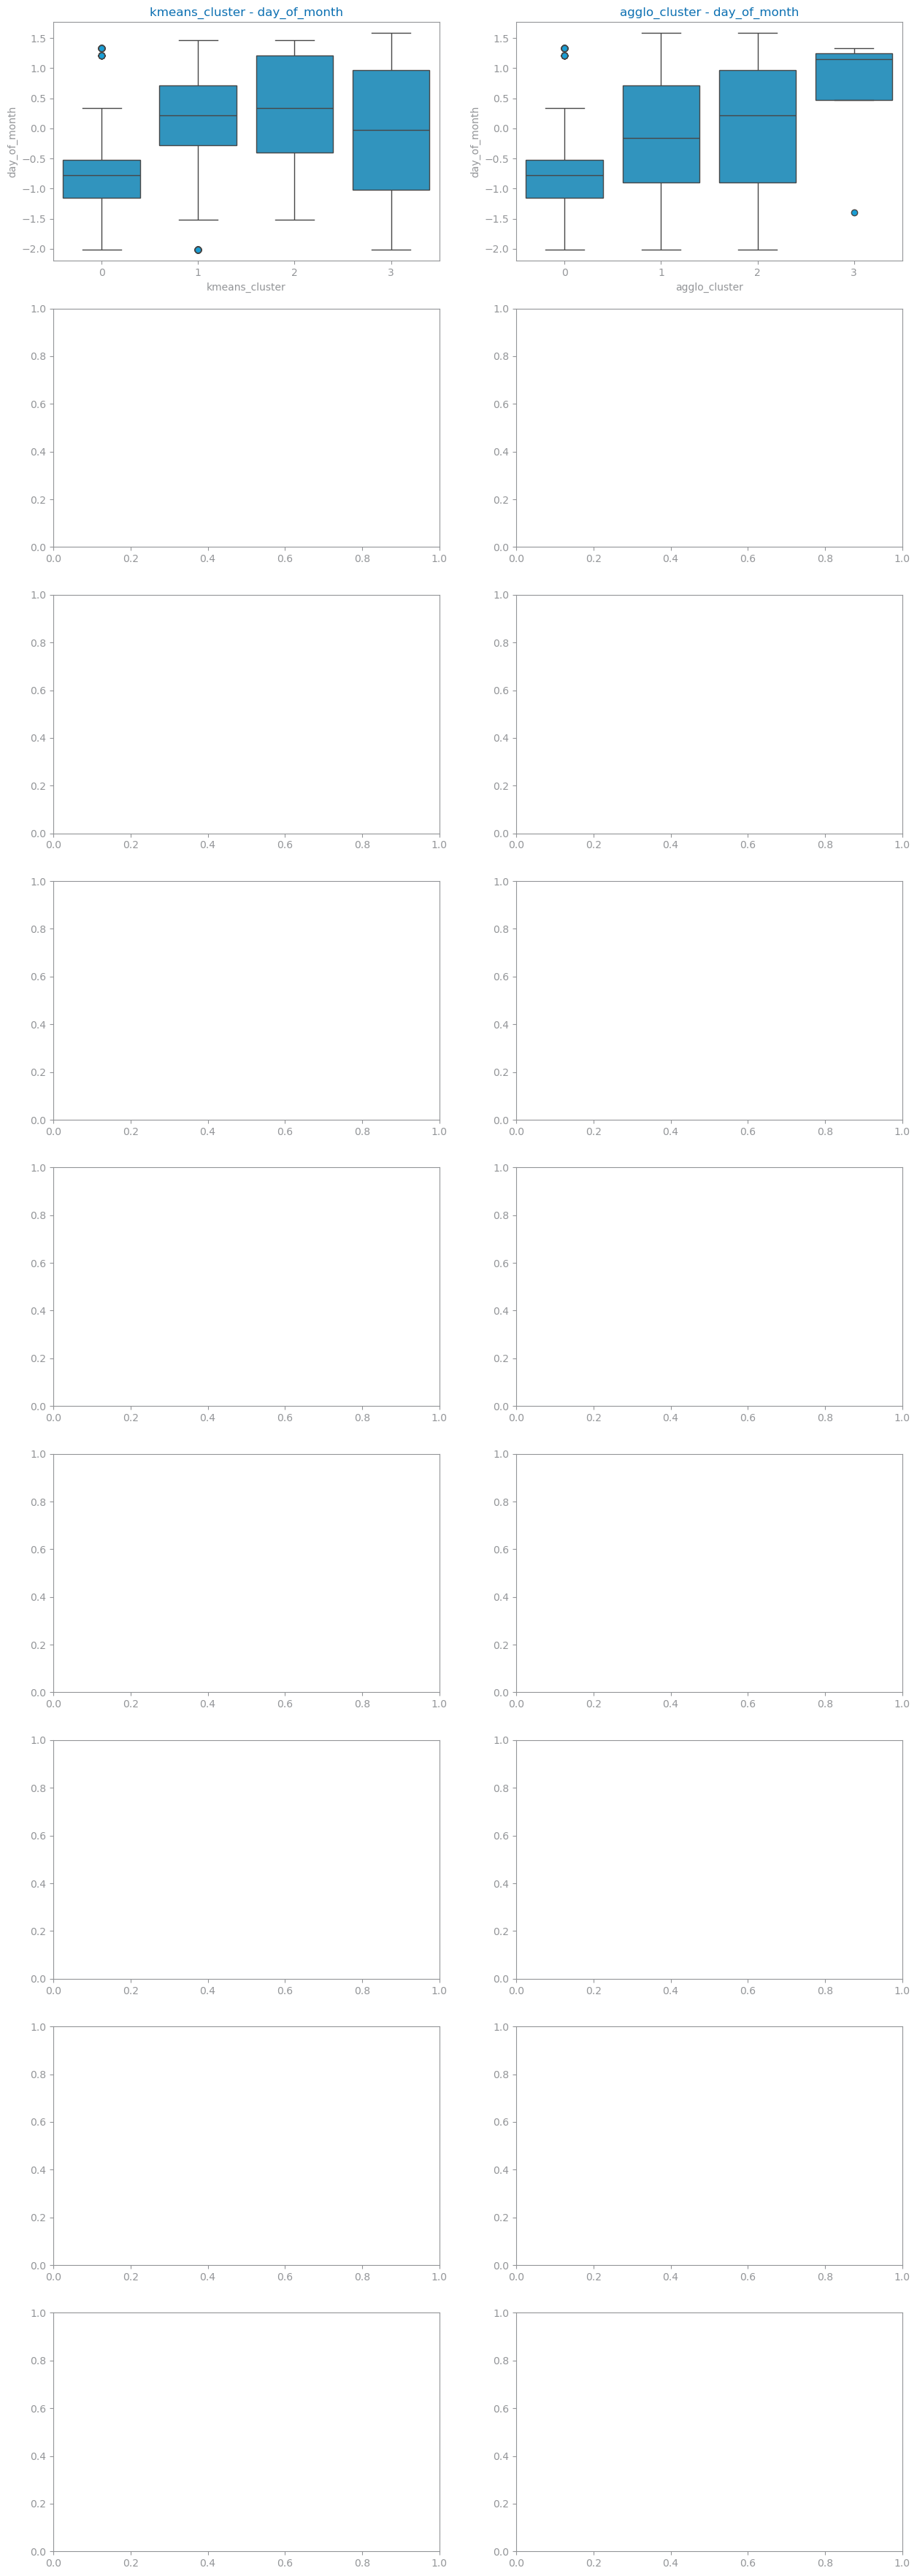

In [559]:
# Example usage
features = numeric


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(df_to_use_clust, features, cluster_labels)

## PCA visualization

In [560]:
from sklearn.decomposition import PCA

#df.drop(columns=['kmeans_cluster', 'agglo_cluster'], inplace=True)

# Visualization
pca_reorder = PCA(n_components=8)
numeric_features_pca = pca_reorder.fit_transform(df_to_use_clust)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.519216,0.584975,-0.045141,1.455878,0.476509,1.887109,-0.390088,2.331949
1,-1.062863,1.104246,-0.688628,1.758082,-0.302176,-1.854963,-0.031112,0.157540
2,-1.326871,2.479458,0.583168,-0.831496,-0.736624,1.181160,-0.847431,-1.155386
3,-0.142001,0.289795,1.179516,-0.600255,-2.318516,0.035848,-2.221436,0.747856
4,-1.476741,-2.539081,0.803138,-0.155553,1.124459,1.423939,-1.128839,0.441736


In [280]:
df.shape

(12774, 17)

## PCA explained variance ratio

In [561]:
# Fit the PCA model


pca_reorder.fit(df_to_use_clust)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
total_variance_explained = explained_variance_reorder.sum()

print(f'Explained variance ratio: {explained_variance_reorder}')
print(f'Total variance explained: {total_variance_explained:.4f}')


Explained variance ratio: [0.10097947 0.08583425 0.08120098 0.07112747 0.06699415 0.0617771
 0.05616871 0.05040858]
Total variance explained: 0.5745


In [284]:
df.columns
df.shape

(12774, 17)

## PCA plot

### 2D PCA Plot

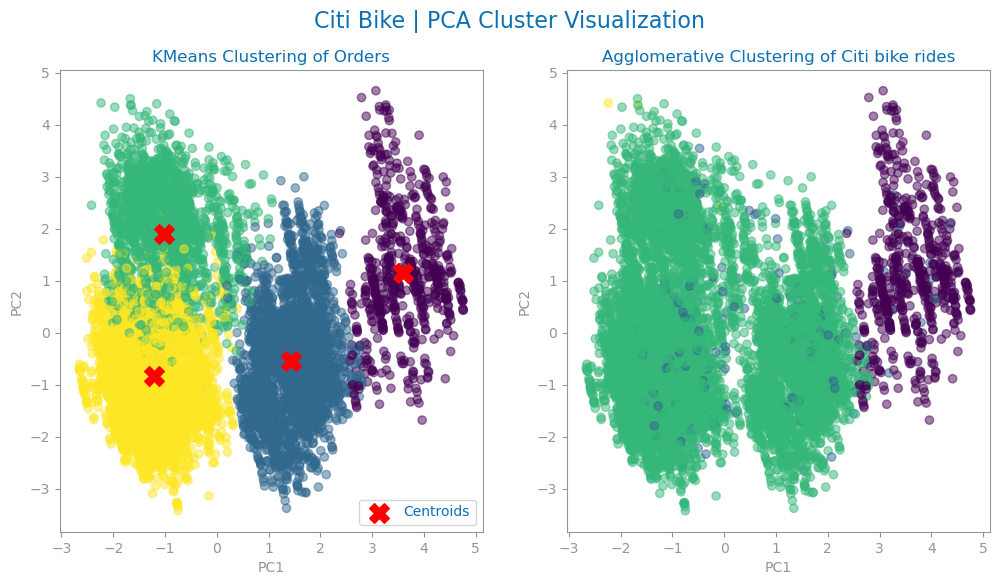

In [564]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca_reorder.transform(citibike_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Citi bike rides')

plt.suptitle(f"{file_tag} | PCA Cluster Visualization", fontsize=16)

plt.show()

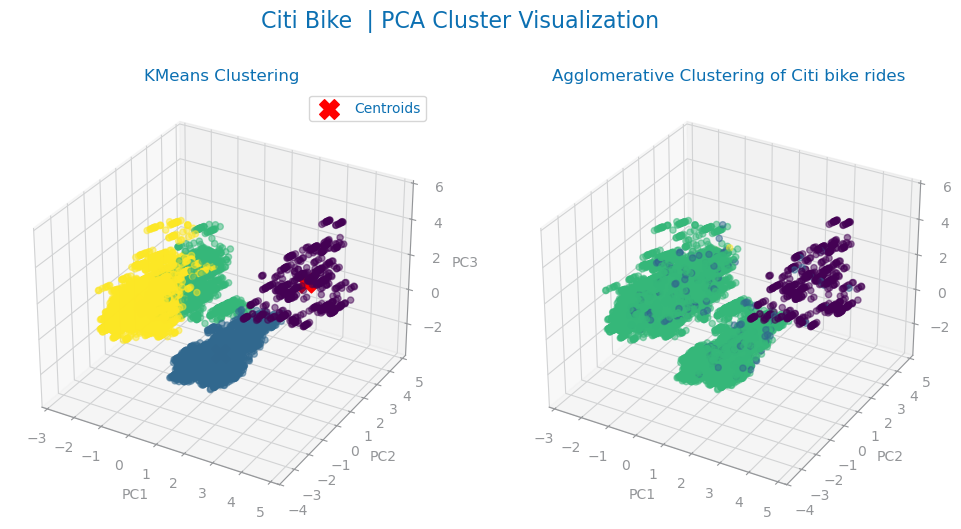

In [565]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca_reorder.transform(citibike_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Kmeans Clustering of Citi bike rides')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Citi bike rides')

fig.suptitle(f"{file_tag}  | PCA Cluster Visualization", fontsize=16)

plt.show()

# TO DO's 

- Data profiling
    - Check if the numeric variables of the dataset follow a normal distribuiton or not
        - check eugenia data profiling code from mod 1 notebook and copy code
Cluster Data prep
    - representar variancia das variaveis num gráfico para depois colocar no report, na parte do fetaure selection (removal redundant variables)
    - Truncate outliers e depois garantir que removemos os outliers restantes, martelando (ver como o João fez)
- Cluster application
    - Função manathan não está a correr no agglomerative clustering, corrigir a função para poder usar a distancia manathan
    - correr o agglomerative clustering com outras distancias
Descrição dos clusters
    - dendograma mexer e perceber o parametro p, para ver o impacto na quantidade de clusters 
    - Corrigir  o boxplot dos clusters labels, é isto que vai permitir descrever depois o centroide dos cluster
    - para descrever os clusters, pedir também à Eugenio o heatmap dos centroides para o kmeans
PCA
- PCA tentar melhorar a explicabilidade dos dados 

